# S-BIAD34

In [2]:
import skimage
import imageio
import numpy as np

In [95]:
def rgb_2_gray_unique(image, channel_last=True):
    """ Function to convert RGB into gray image, but each unique rgb pixel is a unique pixel number in gray image

    Args:
        image: RGB image (width,height,3)
        channel_last: position of the channel axis
    Returns: (width,height)
    """
    if not channel_last:
        image = np.moveaxis(image, 0, -1)

    flat_img = image.reshape(-1,3)
    unique_px = np.unique(flat_img, axis=0) # [0,0,0] always the first unique px value
    gray = np.zeros((image.shape[0]* image.shape[1]), dtype=np.uint8) # (width*height,)
    for i, px_val in enumerate(unique_px):
        indexes = np.where((flat_img == px_val).sum(axis=-1) == 3)[0]
        gray[indexes] = i
    gray = gray.reshape((image.shape[0], image.shape[1]))
    assert len(unique_px) == len(np.unique(gray))
    #print(f"before: {len(unique_px)} unique px, after: {len(np.unique(gray))} unique values")
    #print(gray.shape, gray.dtype)
    return gray

def get_cell_nuclei_masks_ccd(parent_dir, img_id, cell_mask_extension = "w2cytooutline.png", nuclei_mask_extension = "w2nucleioutline.png"):
    #parent_dir = "/data/2Dshapespace/S-BIAD34/Files/HPA040393"
    cyto = imageio.imread(f"{parent_dir}/{img_id}_{cell_mask_extension}")
    cyto = rgb_2_gray_unique(cyto)
    nu = imageio.imread(f"{parent_dir}/{img_id}_{nuclei_mask_extension}")
    nu = rgb_2_gray_unique(nu)

    # Relabel the cytosol region based on nuclei labels
    cell_mask = np.zeros_like(cyto)
    nuclei_mask = np.zeros_like(nu) #nu.copy()
    nu_regionprops = skimage.measure.regionprops(nu)
    cyto_regionprops = skimage.measure.regionprops(cyto)
    matched_ID = []
    for region in nu_regionprops:
        new_label = region.label
        match = dict()
        x1 = [str(x) for x in region.coords]
        for r in cyto_regionprops:
            if r.label in matched_ID:
                continue
            x2 = [str(x) for x in r.coords]
            overlap_px = set(x1).intersection(x2)
            if len(overlap_px)> 0:
                match[str(r.label)] = len(overlap_px)
        if len(match.keys())==0:
            # If don't find any corresponding cell/nuclei, delete this mask
            print(f'Dont find cell {new_label}')
            #nuclei_mask[nu == new_label] = 0
        else:
            # if find multiple matches, pick the highest overlap. This case include the case with only 1 match
            highest_match= max(match, key= lambda x: match[x])
            #print(highest_match, new_label)
            cell_mask[cyto == int(highest_match)] = new_label
            nuclei_mask[nu == new_label] = new_label
            matched_ID += [int(highest_match)]
    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask))
    """
    cell_mask_ = skimage.morphology.erosion(nuclei_mask, skimage.morphology.square(3)) + cell_mask
    # remove small patches
    cell_mask_ = skimage.morphology.erosion(cell_mask_, skimage.morphology.square(5))
    cell_mask_ = skimage.morphology.dilation(cell_mask_, skimage.morphology.square(5))
    """
    cell_mask_ = cell_mask
    
    protein = imageio.imread(f"{parent_dir}/{img_id}_w4_Rescaled.tif")
    if protein.shape != cell_mask_.shape:
        d_type = 'uint16' #protein.dtype
        max_val = 65535 #protein.max()
        protein = (skimage.transform.resize(protein, cell_mask_.shape)*max_val).astype(d_type)

    return cell_mask_, nuclei_mask, protein


def get_single_cell_mask(cell_mask, nuclei_mask, protein, keep_cell_list, rm_border=True, remove_size=100, plot=False):
    if rm_border:
        nuclei_mask = skimage.segmentation.clear_border(nuclei_mask)
        keep_value = np.unique(nuclei_mask)
        borderedcellmask = np.array([[x_ in keep_value for x_ in x] for x in cell_mask]).astype('uint8')
        cell_mask = cell_mask*borderedcellmask
    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)) 
    for region_c, region_n in zip(
        skimage.measure.regionprops(cell_mask), skimage.measure.regionprops(nuclei_mask)
    ):  
        if region_c.label not in keep_cell_list:
            continue
        if region_c.area < remove_size:
            continue
        # draw rectangle around segmented cell and
        # apply a binary mask to the selected region, to eliminate signals from surrounding cell
        minr, minc, maxr, maxc = region_c.bbox
        # get mask
        mask = cell_mask[minr:maxr, minc:maxc].astype(np.uint8)
        mask[mask != region_c.label] = 0
        mask[mask == region_c.label] = 1
        if True: #erose and dilate to remove the small line
            mask = skimage.morphology.erosion(mask, skimage.morphology.square(5))
            mask = skimage.morphology.dilation(mask, skimage.morphology.square(5))
            # get new bbox
            minr_, minc_, maxr_, maxc_ = skimage.measure.regionprops(mask)[0].bbox
            mask = mask[minr_:maxr_, minc_:maxc_]
            minr += minr_
            minc += minc_
            maxr = minr + (maxr_ - minr_)
            maxc = minc + (maxc_ - minc_)
            
            
        mask_n = nuclei_mask[minr:maxr, minc:maxc].astype(np.uint8)
        mask_n[mask_n != region_n.label] = 0
        mask_n[mask_n == region_n.label] = 1

        pr = protein[minr:maxr, minc:maxc].copy()
        pr[mask != 1] = 0

        if plot:
            plt.figure(figsize=(10, 10))
            plt.imshow(mask)
            plt.imshow(mask_n, alpha=0.5)

        if plot:
            fig = plt.imshow(pr)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False) 
            
        if plot:
            plt.figure(figsize=(10, 10))
            plt.imshow(mask)
            plt.imshow(mask_n, alpha=0.5)
            plt.axis("off")
            plt.tight_layout()
            plt.title(f"{region_c.label}")
            #plt.savefig(f"{save_path}{region_c.label}.jpg", bbox_inches="tight")

In [78]:
parent_dir = "/mnt/c/Users/trang.le/Desktop/shapemode/S-BIAD34/Files/HPA047549"
img_id = "5985_B03_s5"
cell_, nuclei_, protein_ = get_cell_nuclei_masks_ccd(parent_dir, img_id, cell_mask_extension = "w2cytooutline.png", nuclei_mask_extension = "w2nucleioutline.png")

In [85]:
cell_mask_ = skimage.morphology.erosion(nuclei_, skimage.morphology.square(3)) + cell_
# remove small patches
cell_mask_ = skimage.morphology.erosion(cell_mask_, skimage.morphology.square(5))
cell_mask_ = skimage.morphology.dilation(cell_mask_, skimage.morphology.square(5))

In [80]:
cell_idx_n = np.unique(nuclei_)
cell_idx_c = np.unique(cell_)
len(set(cell_idx_n).intersection(cell_idx_c)), len(cell_idx_n), nuclei_.shape, cell_.shape

(70, 70, (1080, 1080), (1080, 1080))

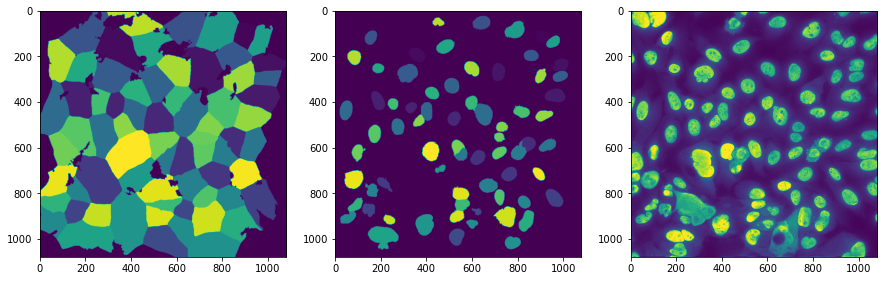

In [86]:
import matplotlib.pyplot as plt
cell = np.stack([nuclei_, np.zeros_like(nuclei_),cell_]).transpose(1,2,0)
fig, ax = plt.subplots(1,3, figsize=(15,35))
ax[0].imshow(cell_mask_)#[cell_==3][0])
ax[1].imshow(nuclei_)#[nuclei_==3][0])
ax[2].imshow(protein_)

In [90]:
cell_mask_==2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

/tmp/ipykernel_1308/3475303242.py:118: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


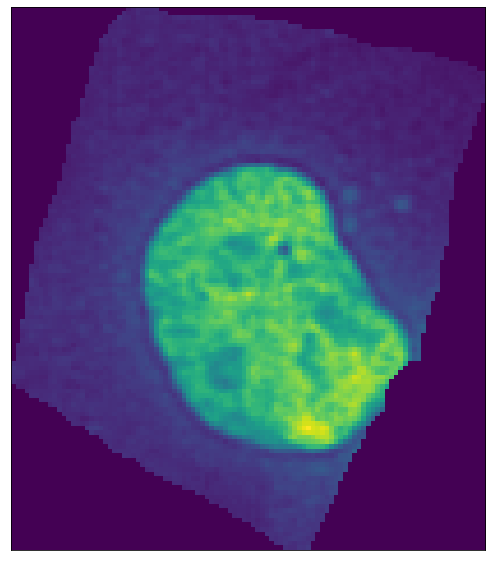

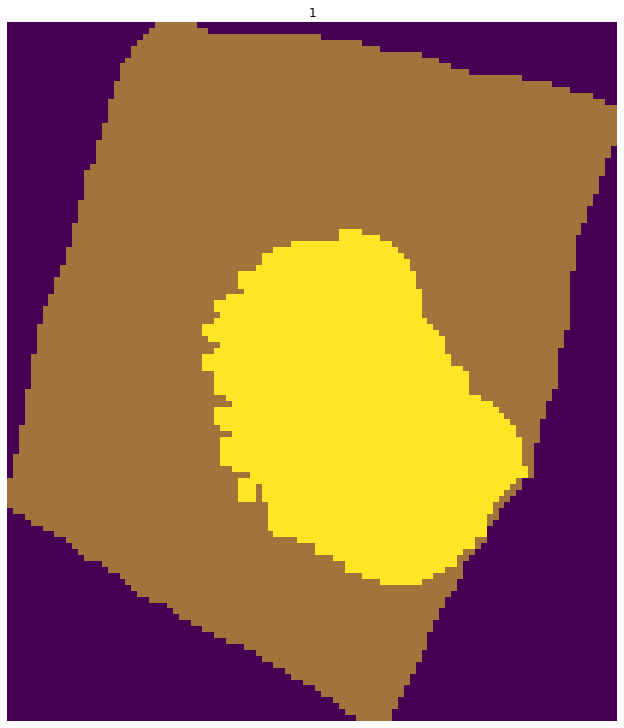

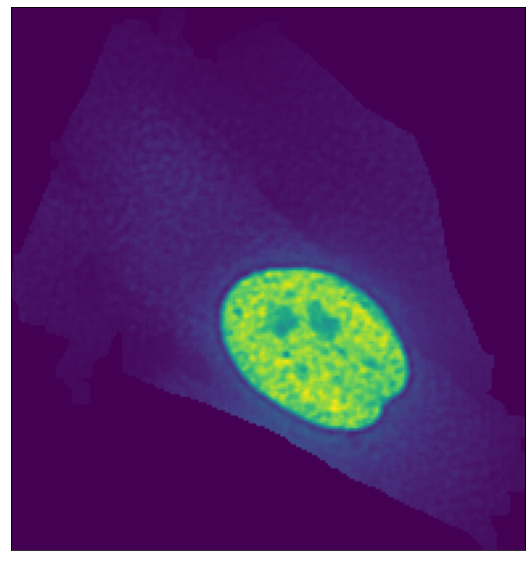

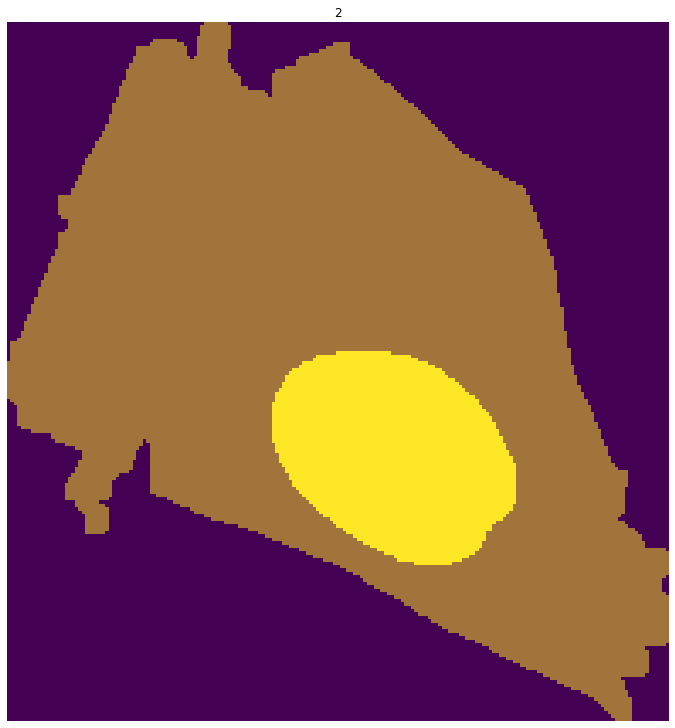

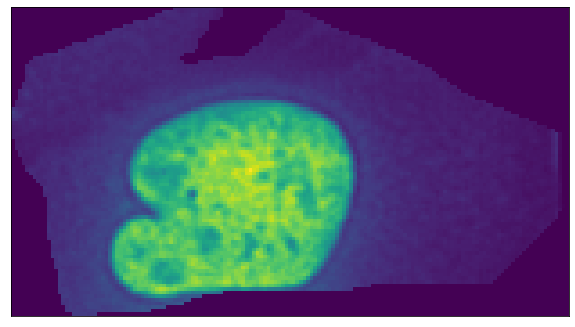

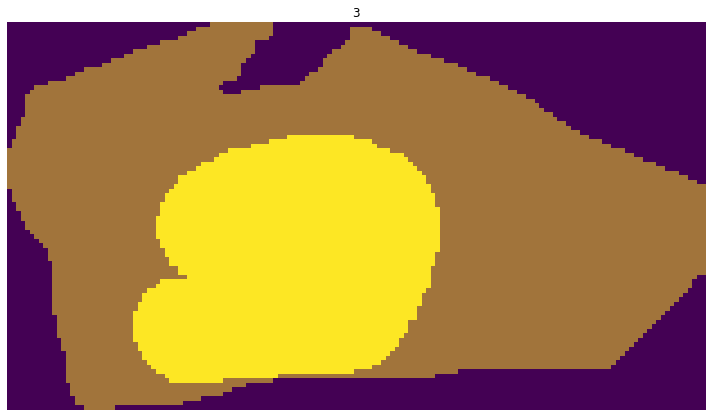

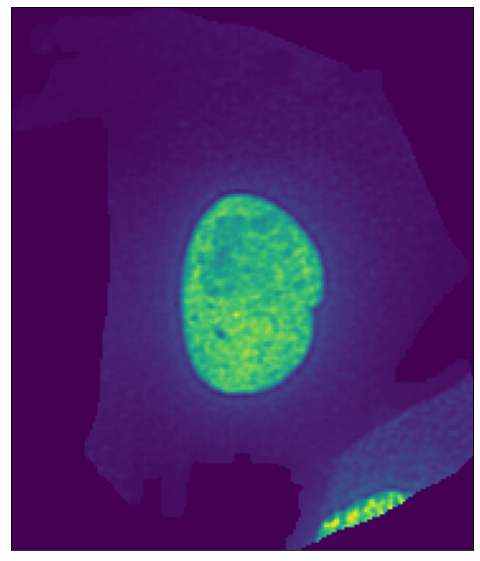

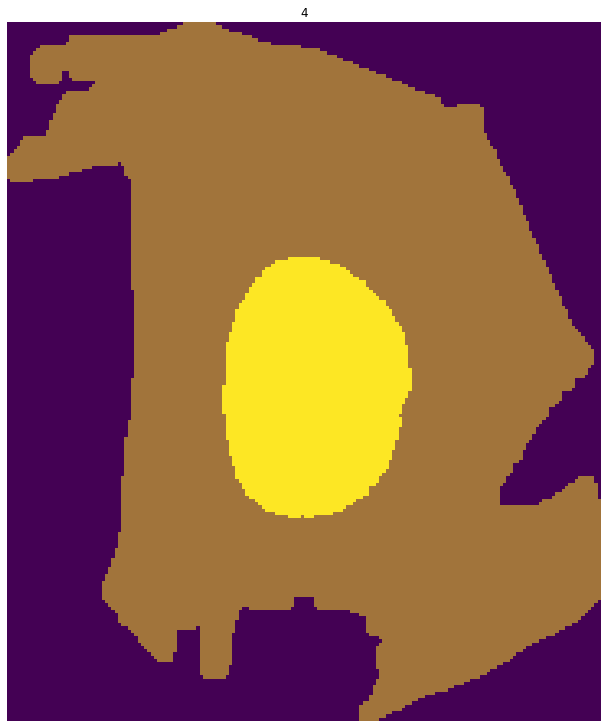

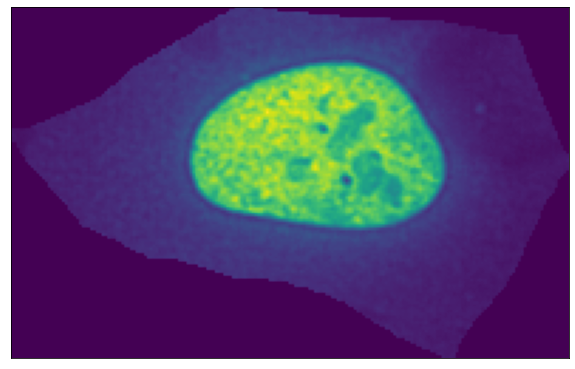

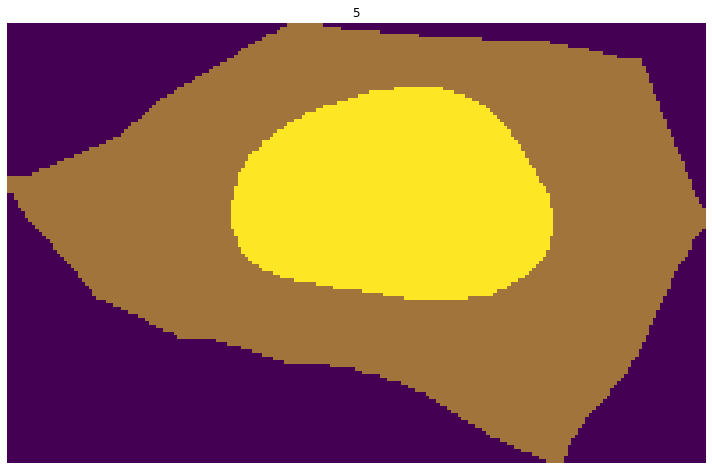

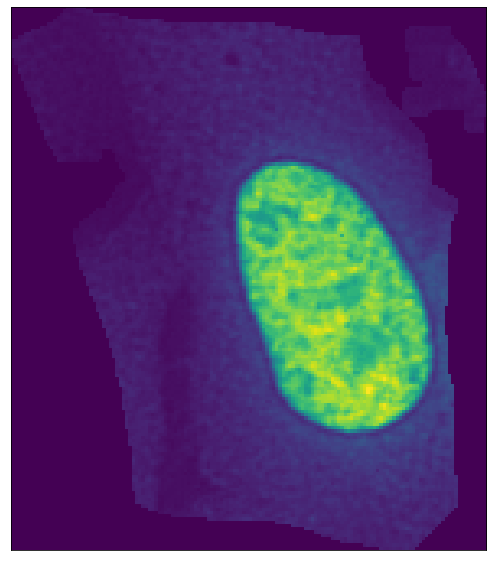

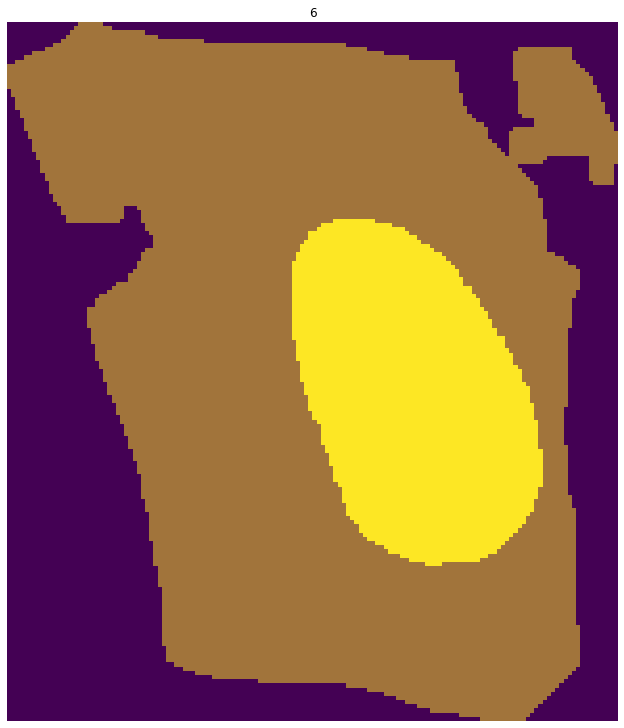

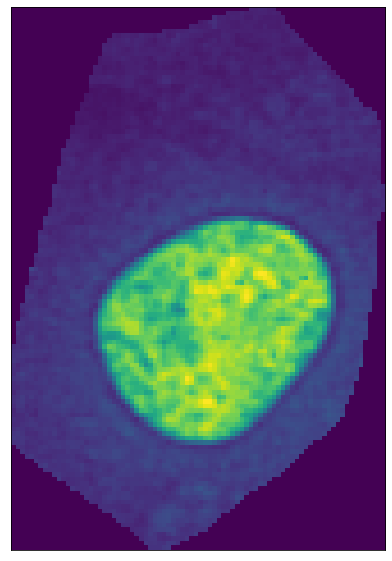

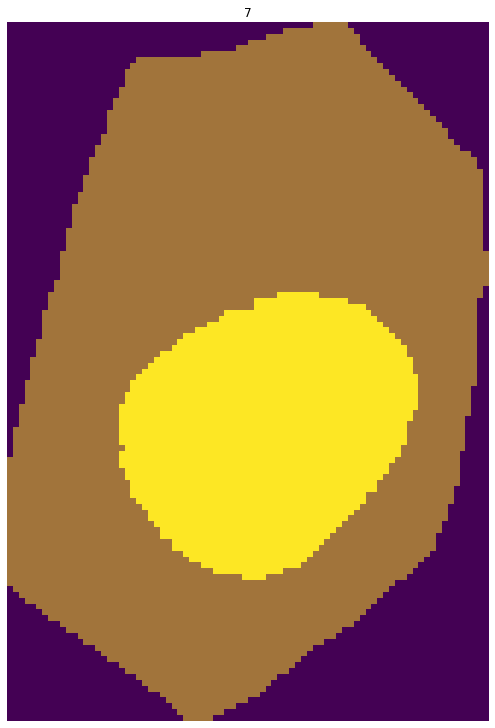

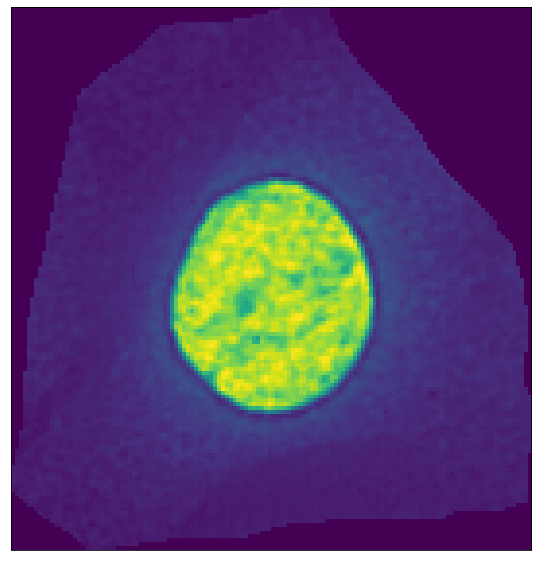

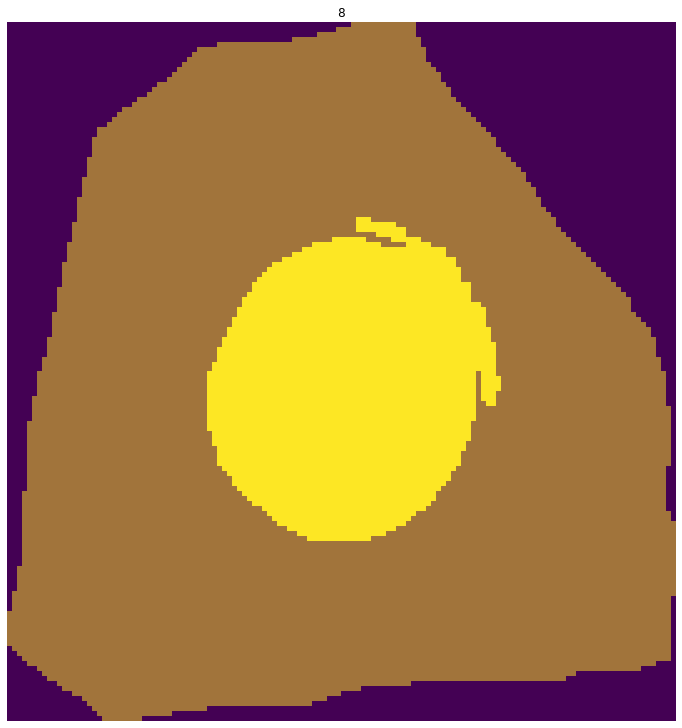

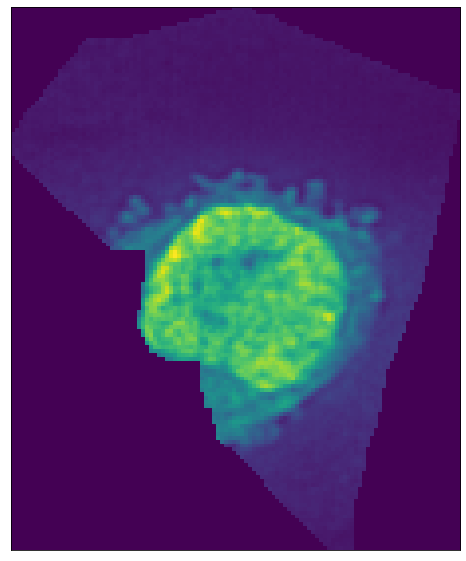

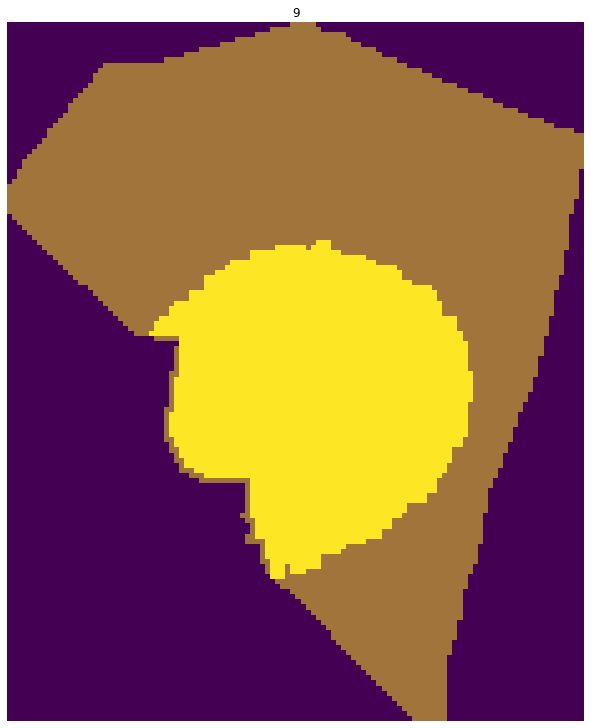

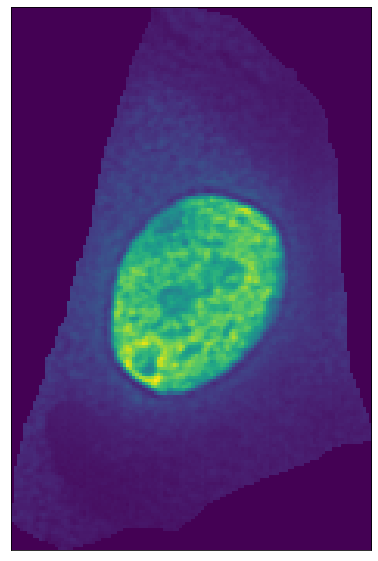

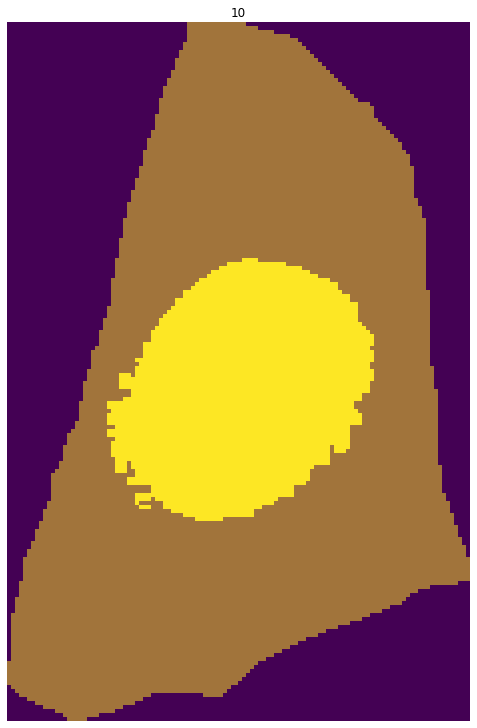

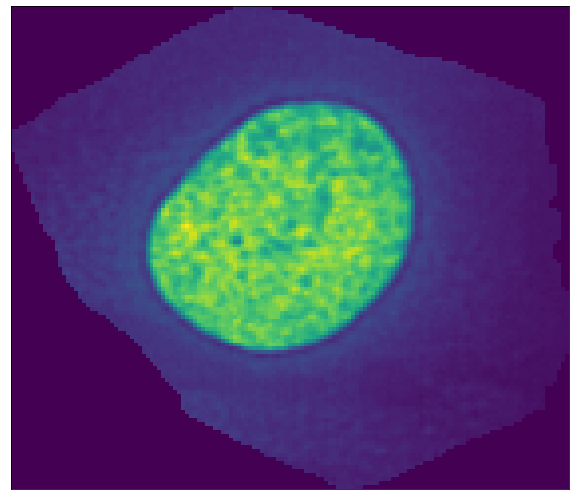

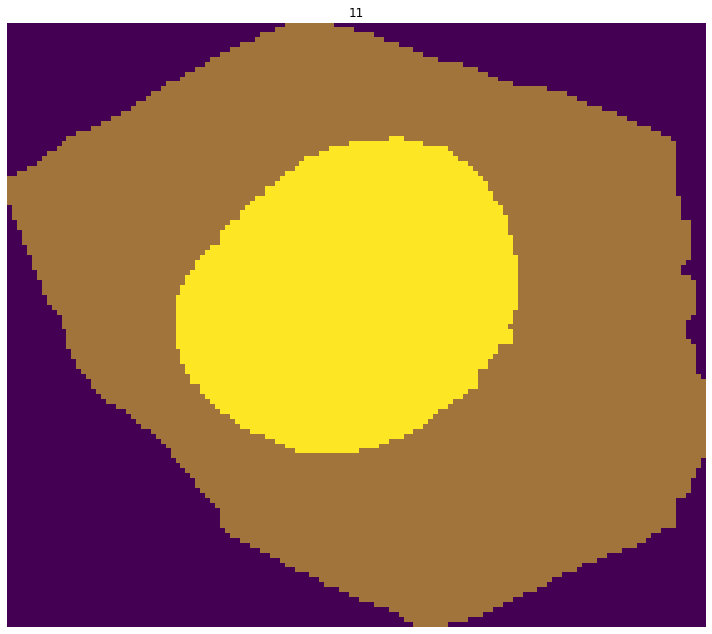

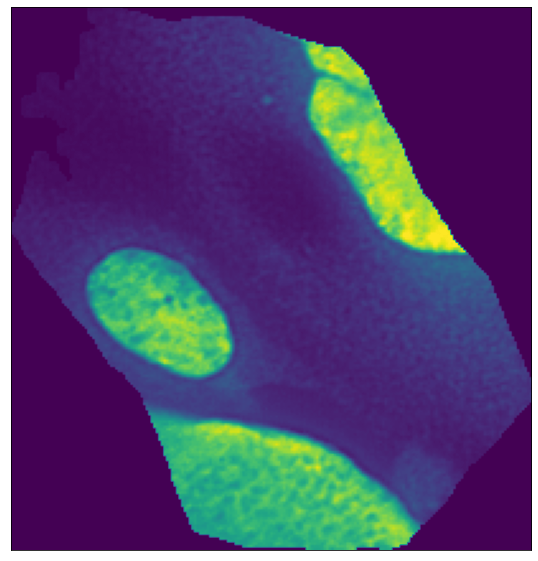

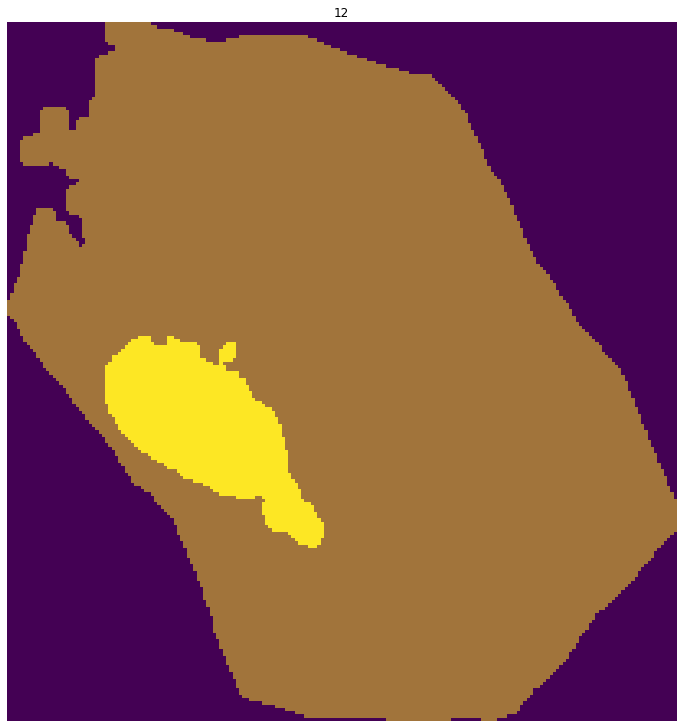

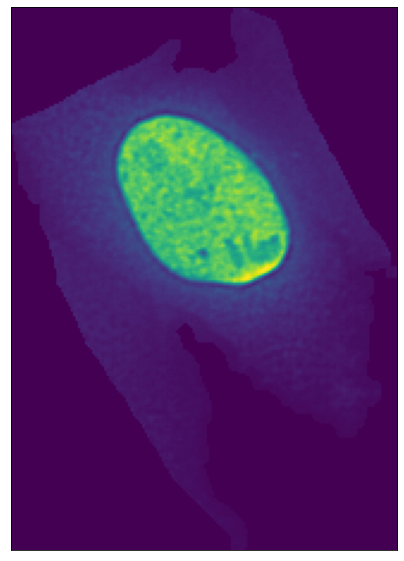

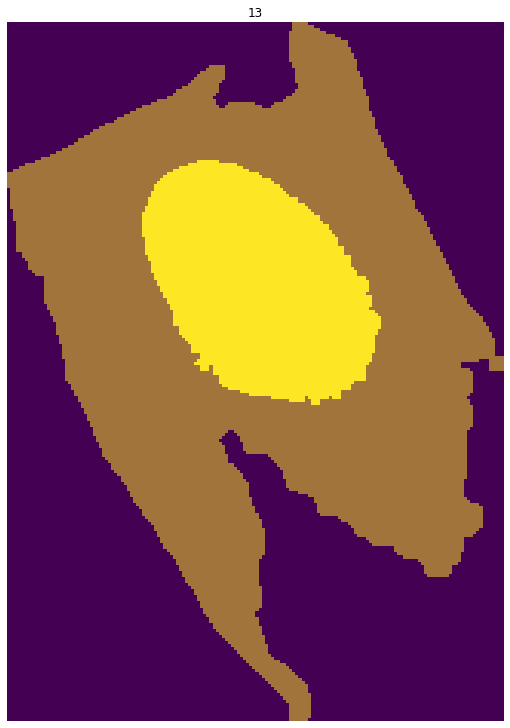

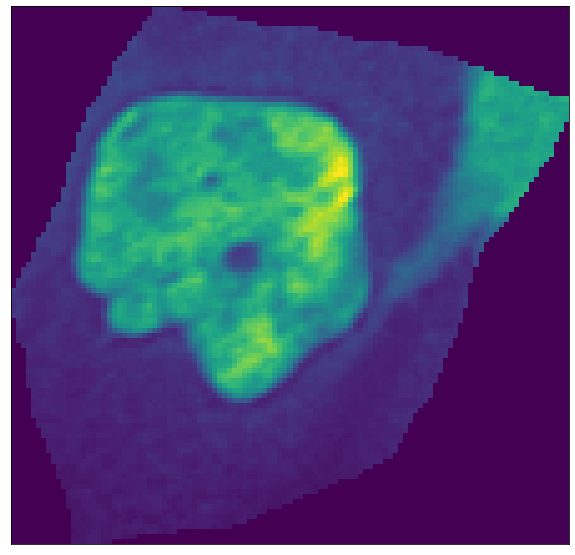

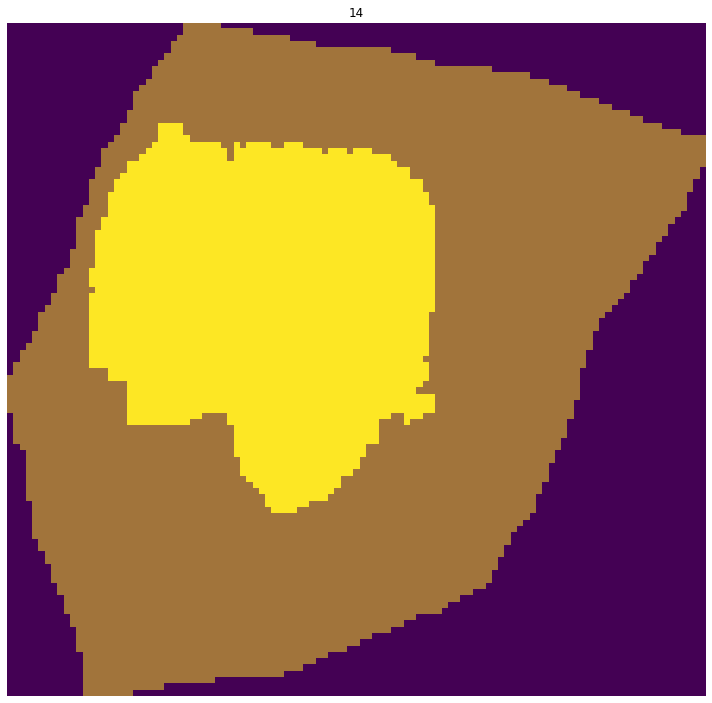

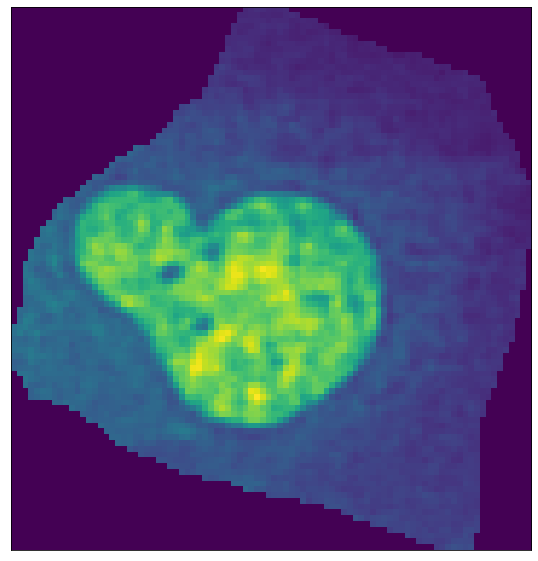

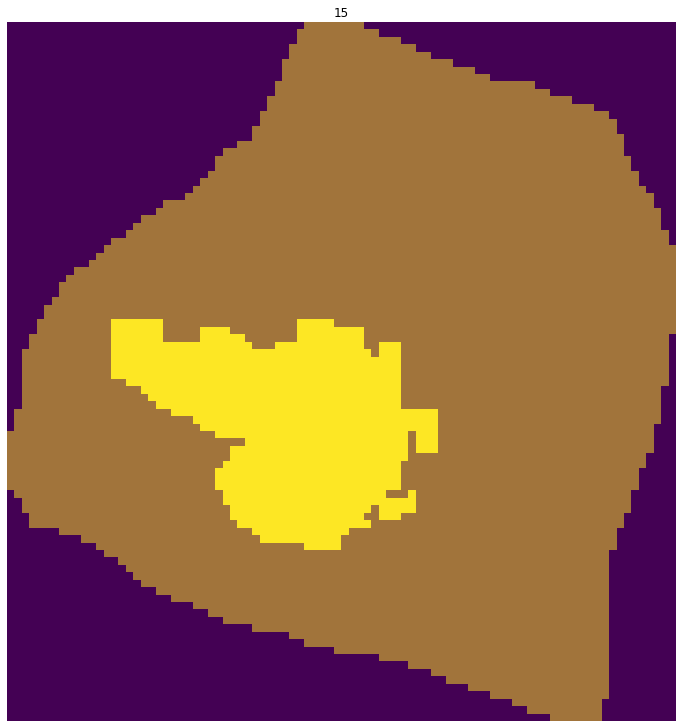

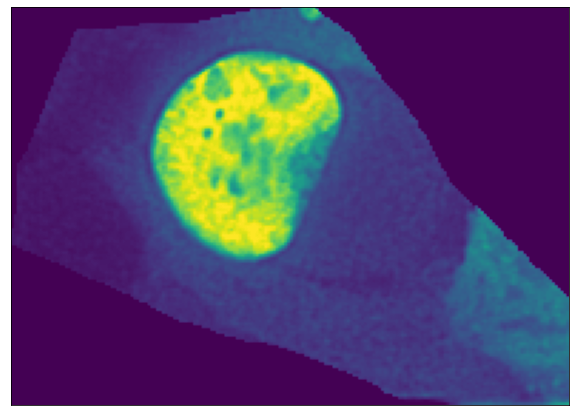

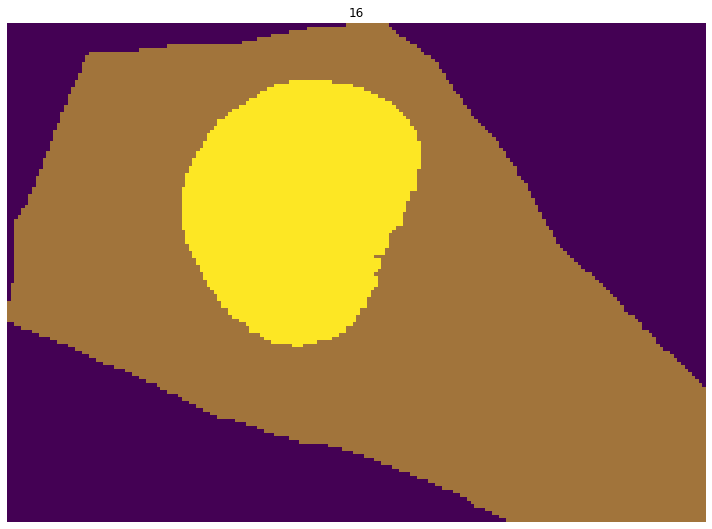

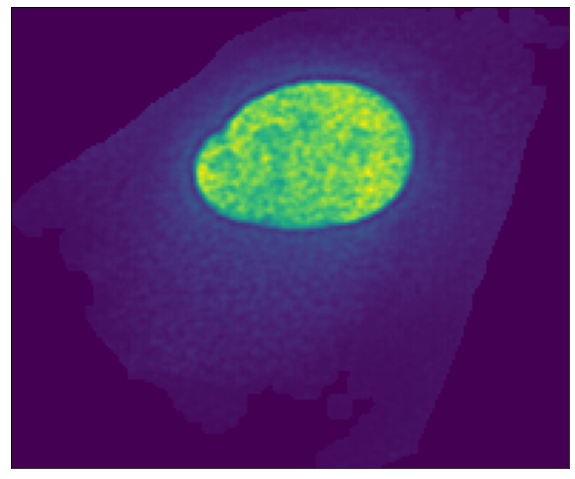

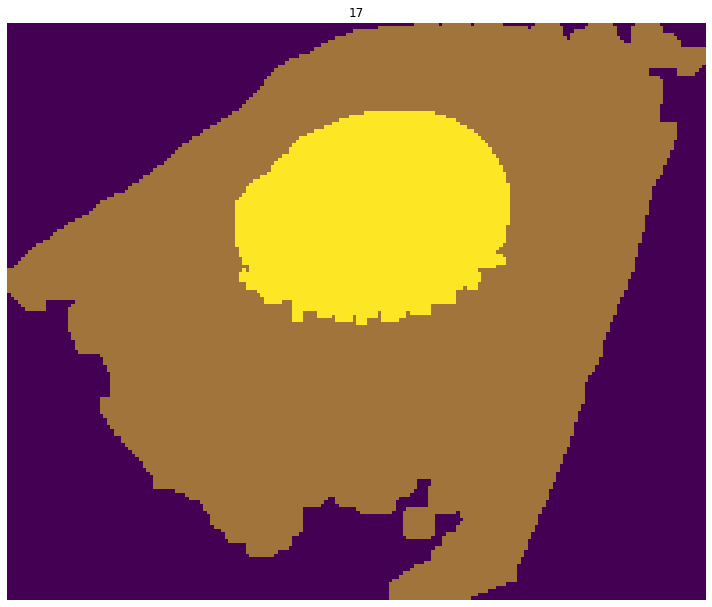

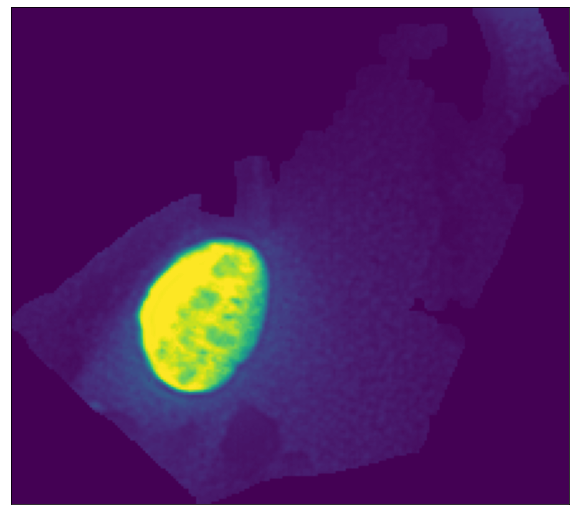

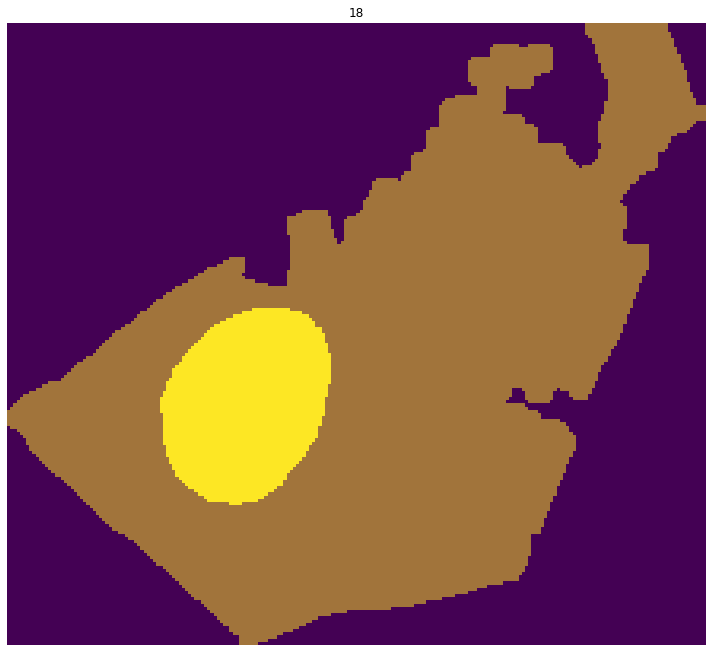

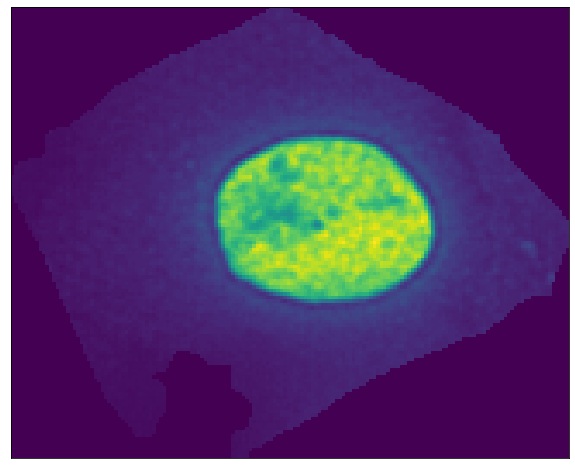

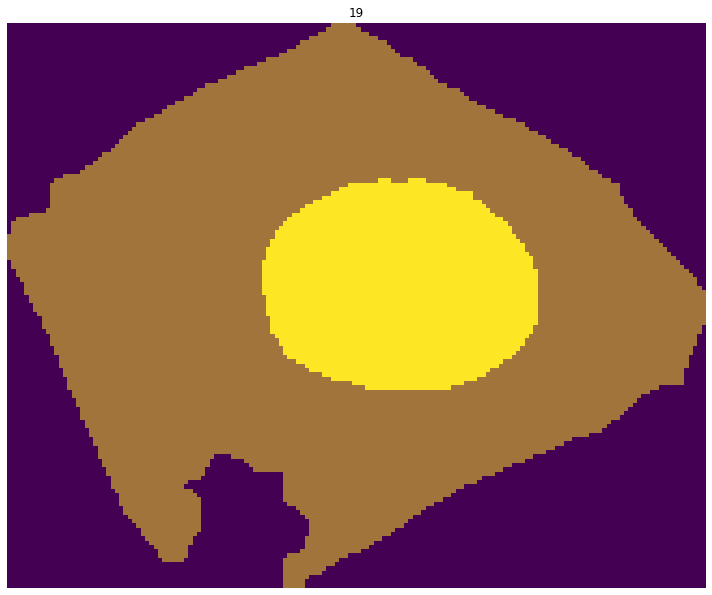

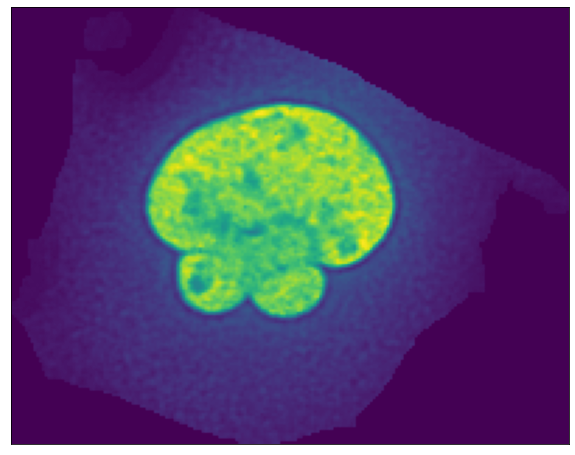

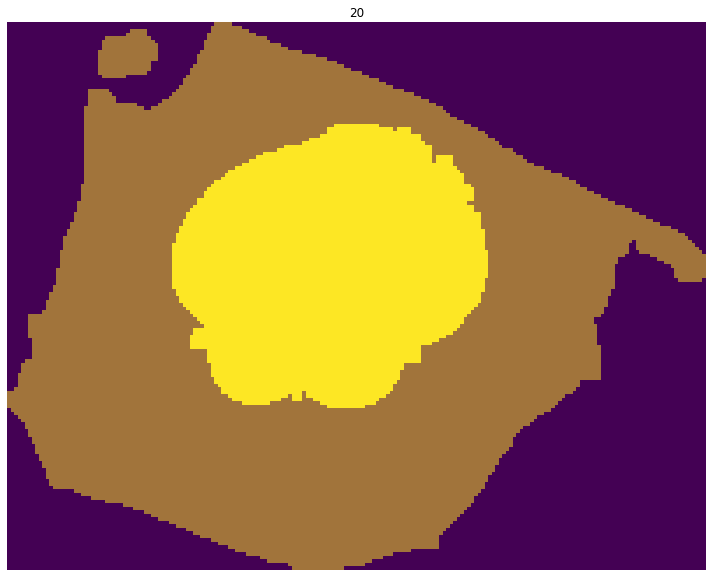

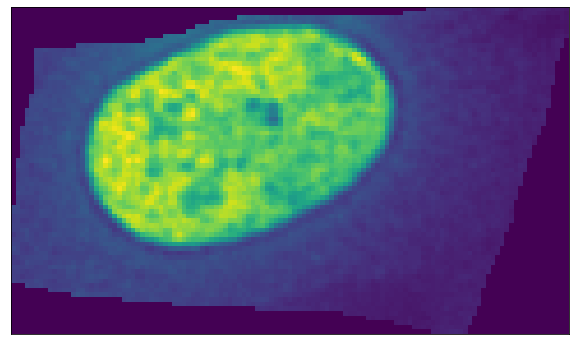

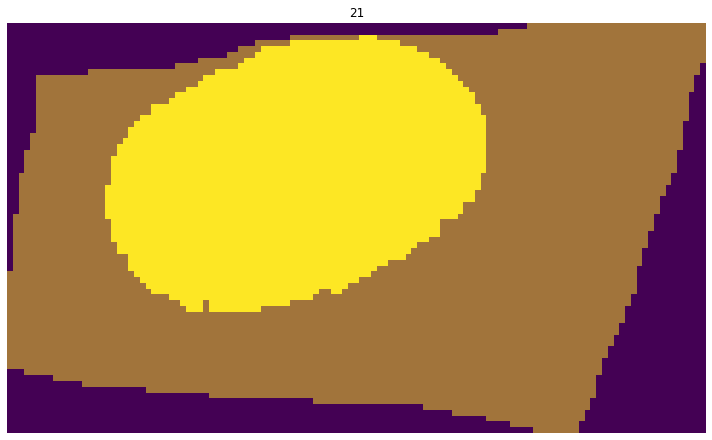

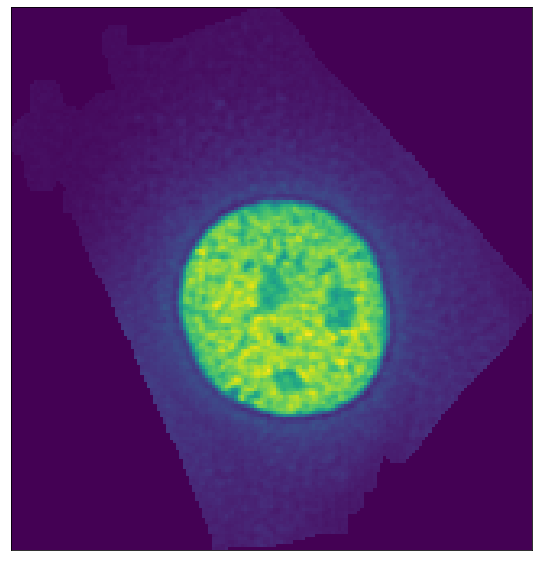

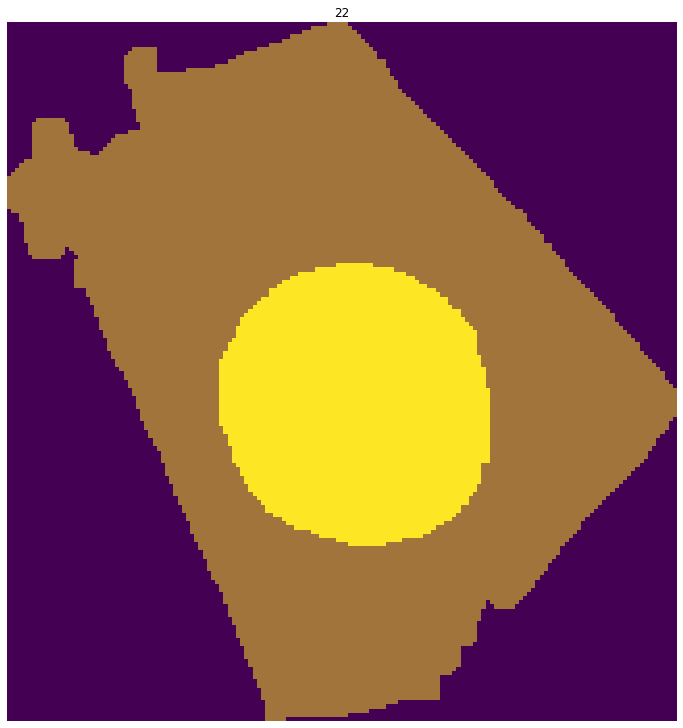

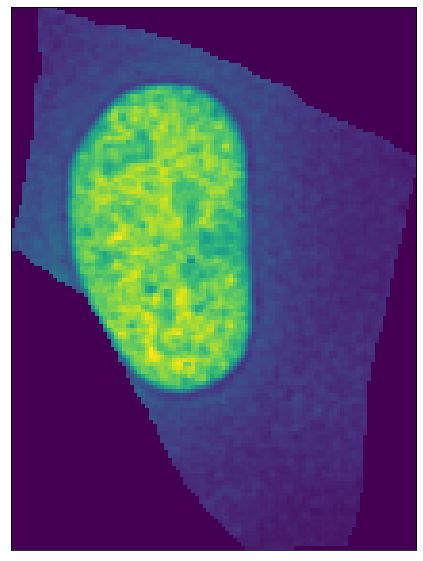

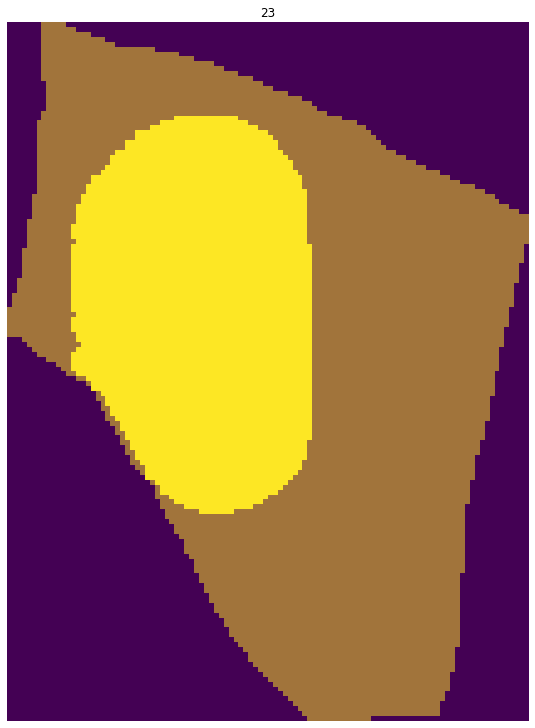

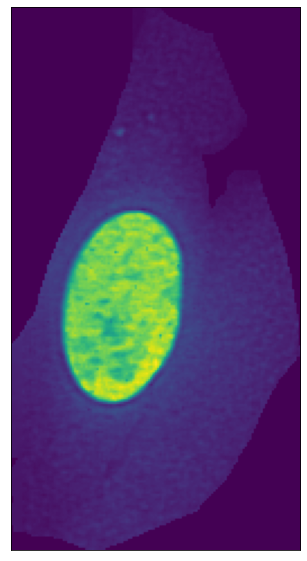

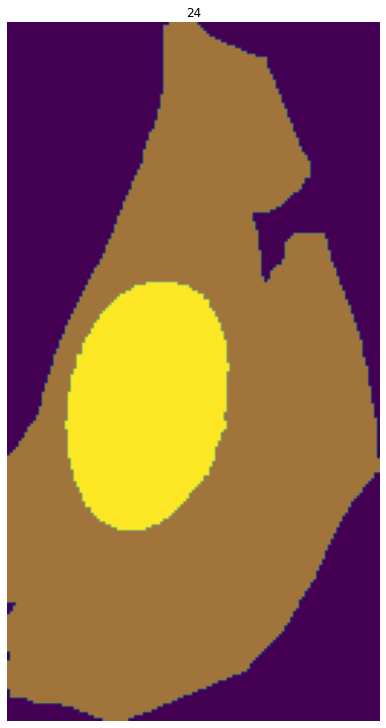

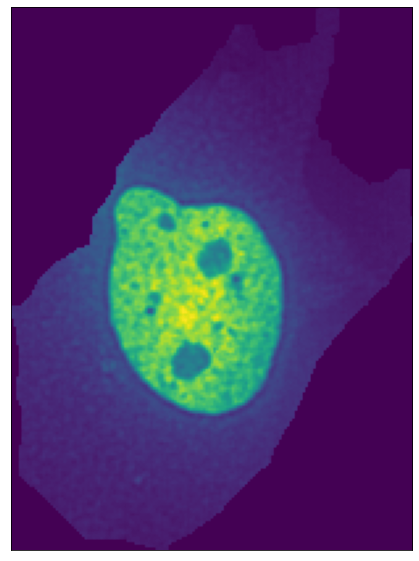

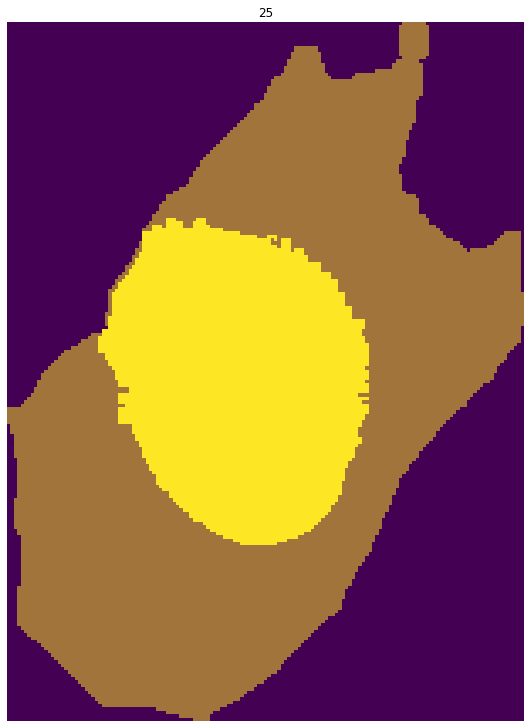

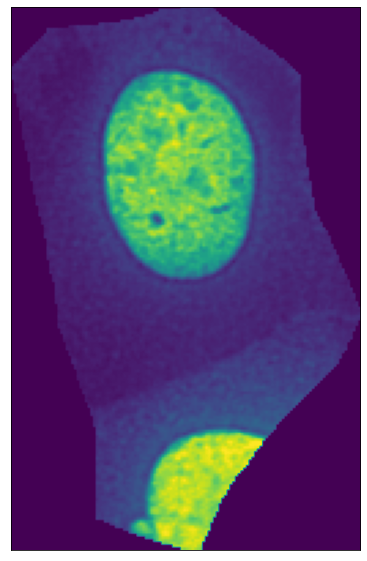

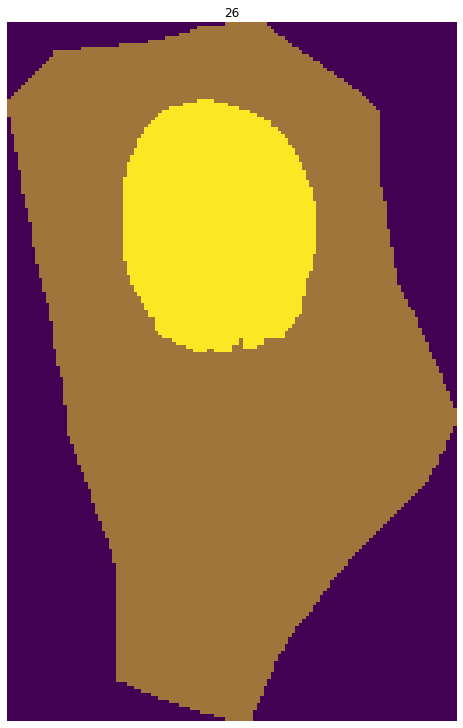

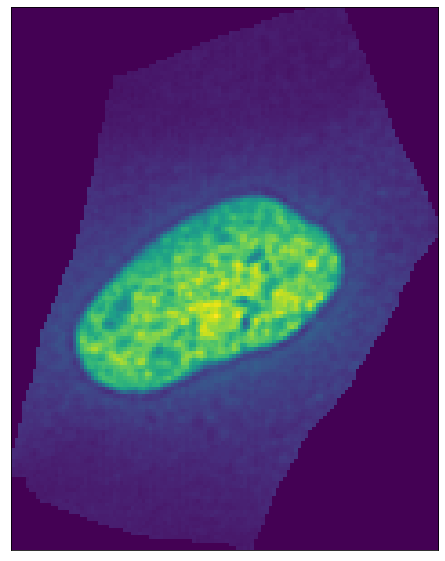

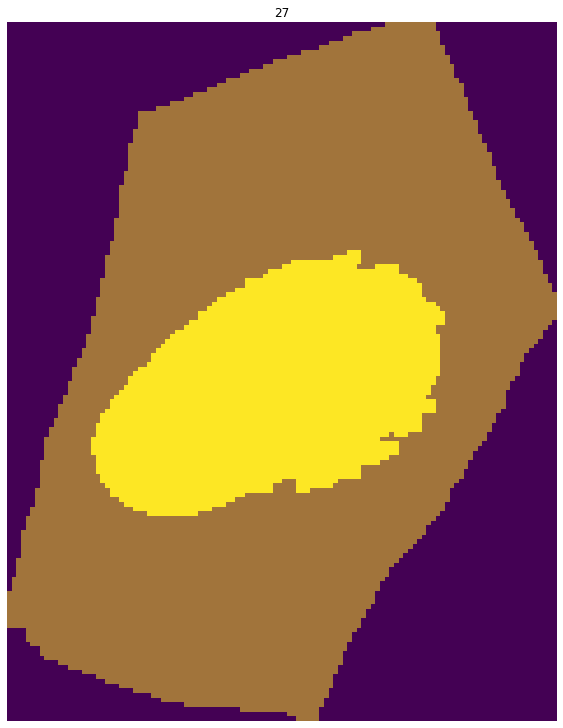

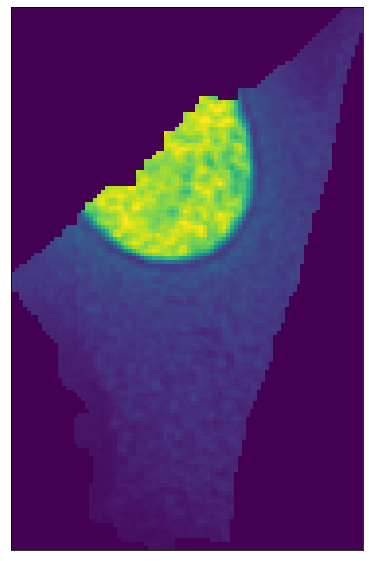

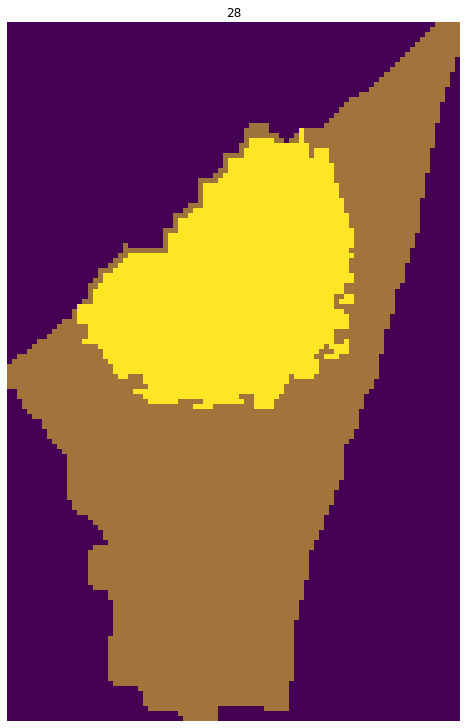

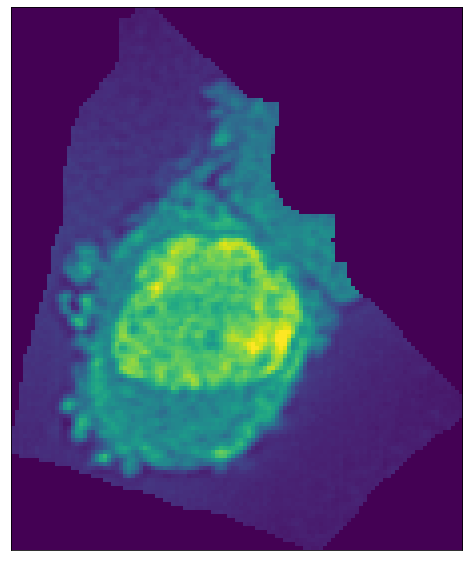

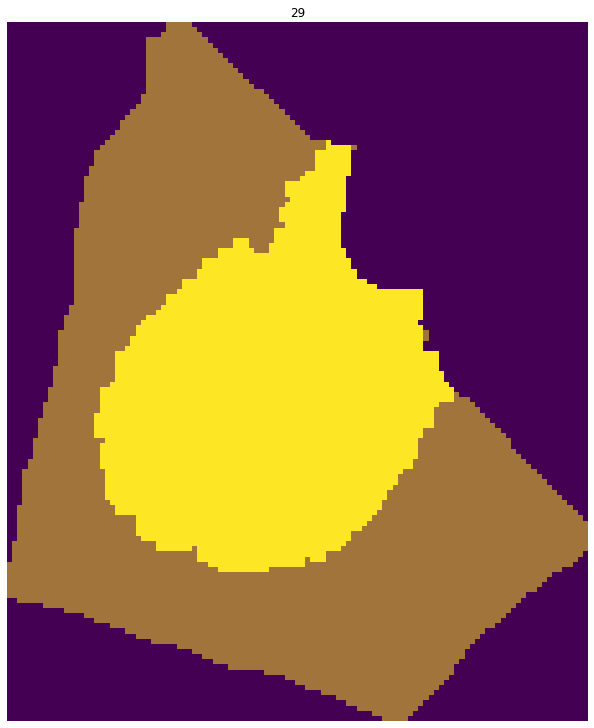

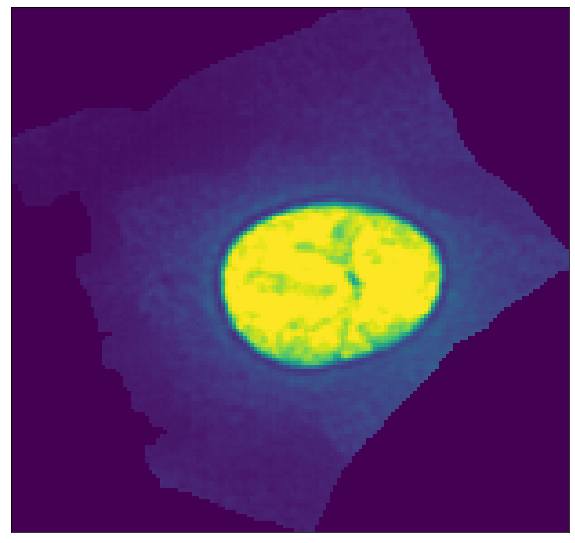

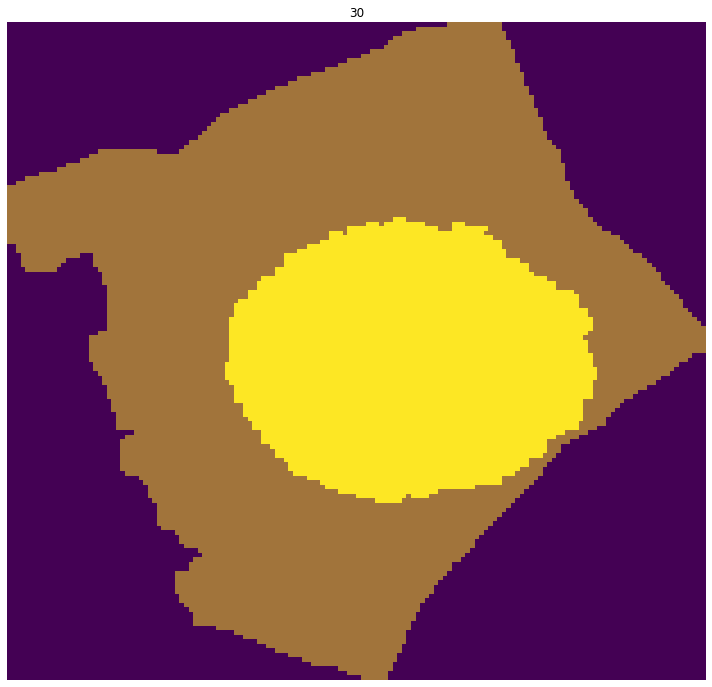

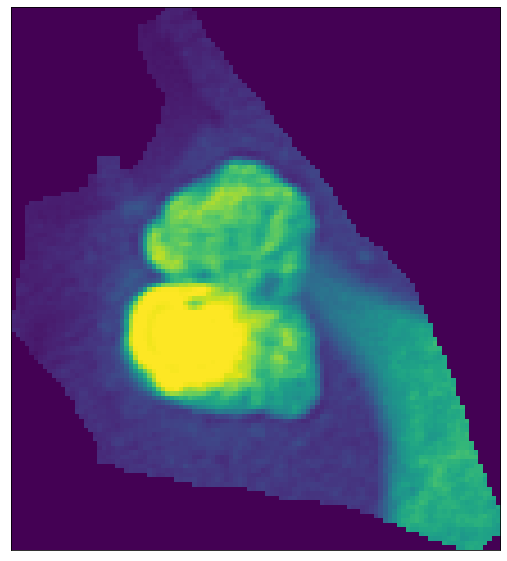

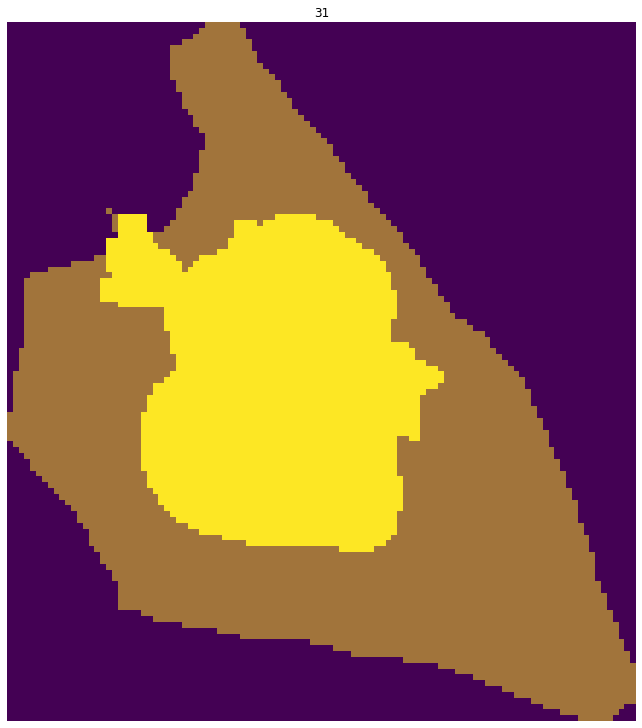

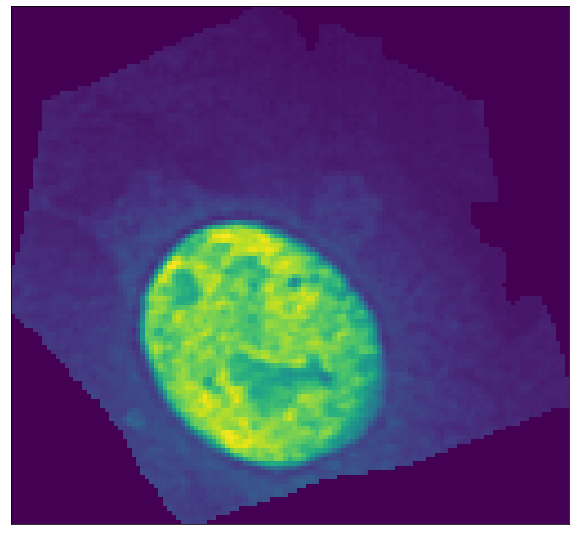

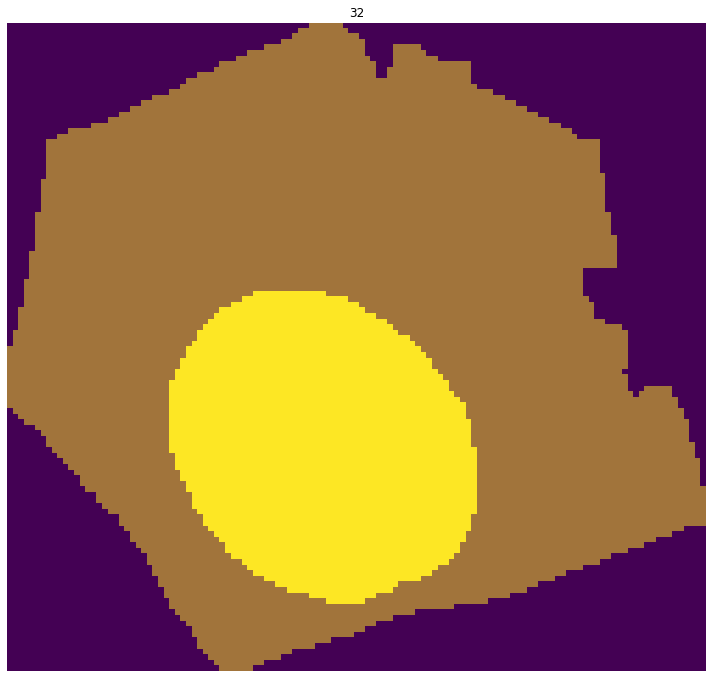

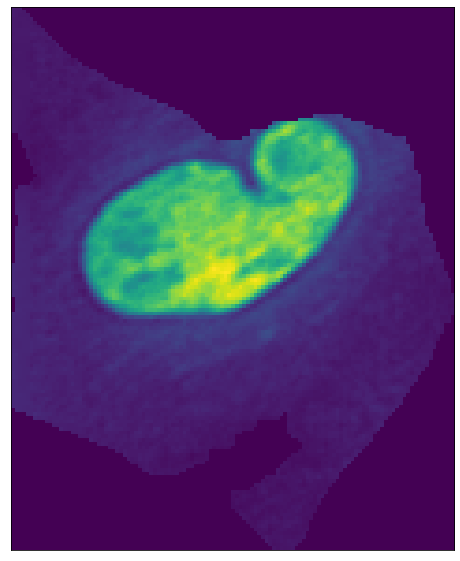

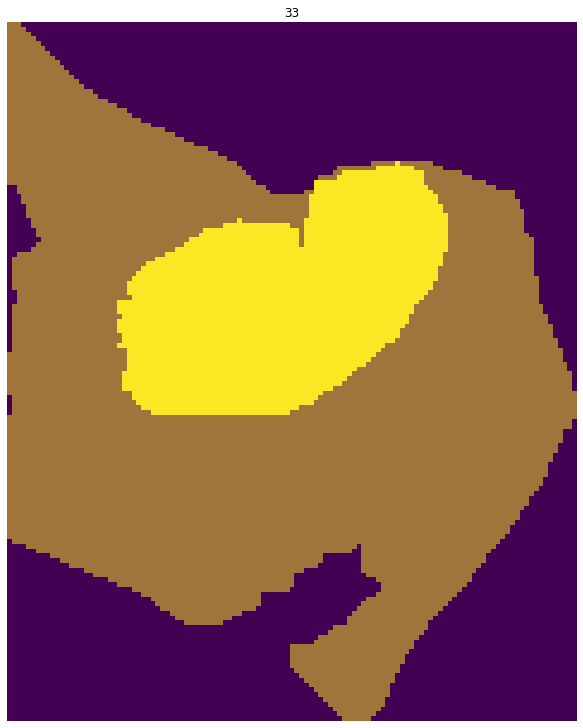

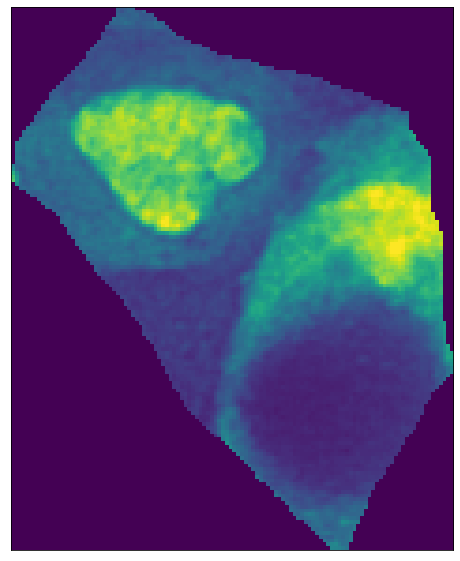

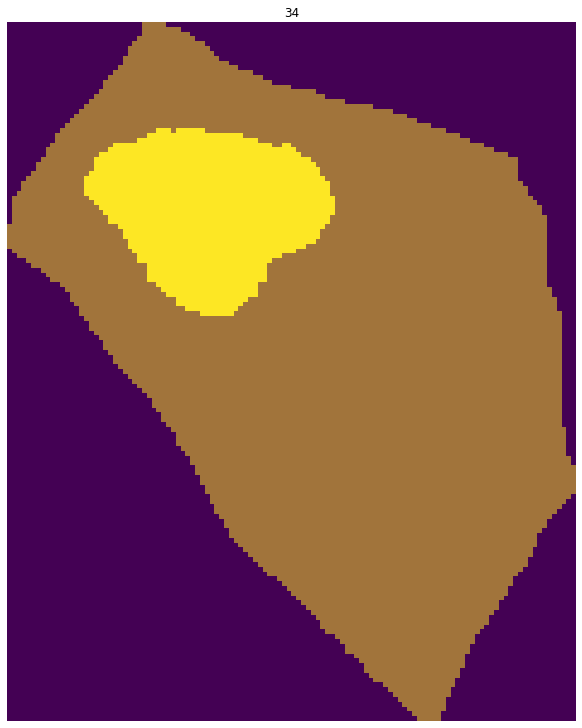

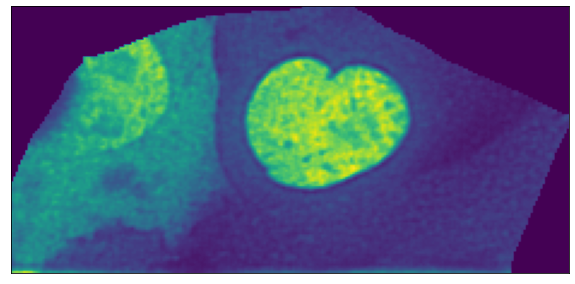

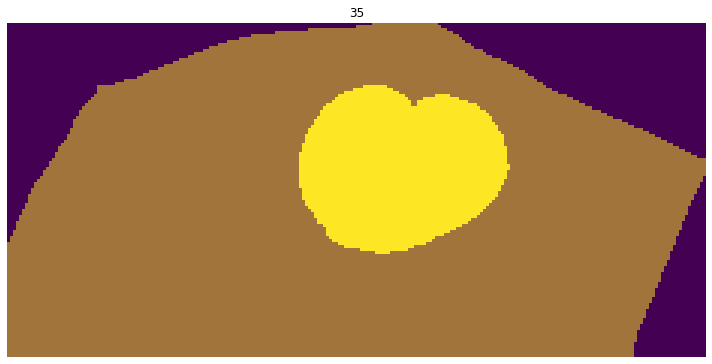

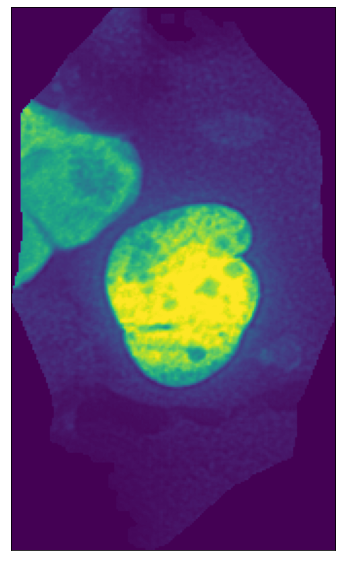

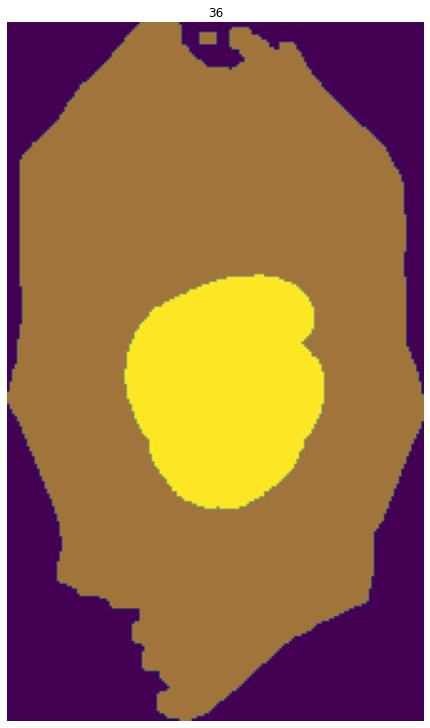

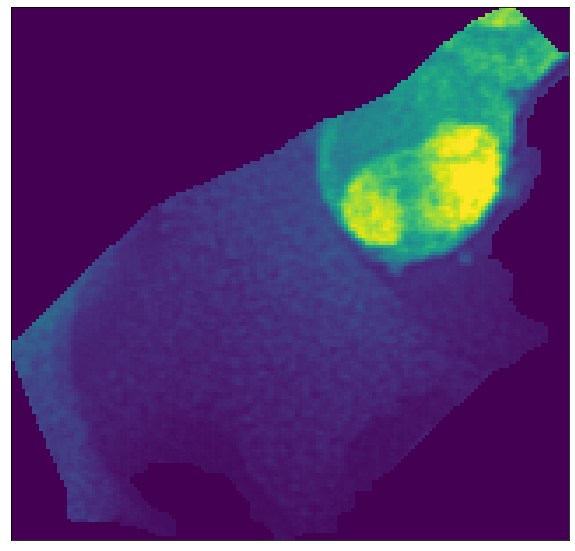

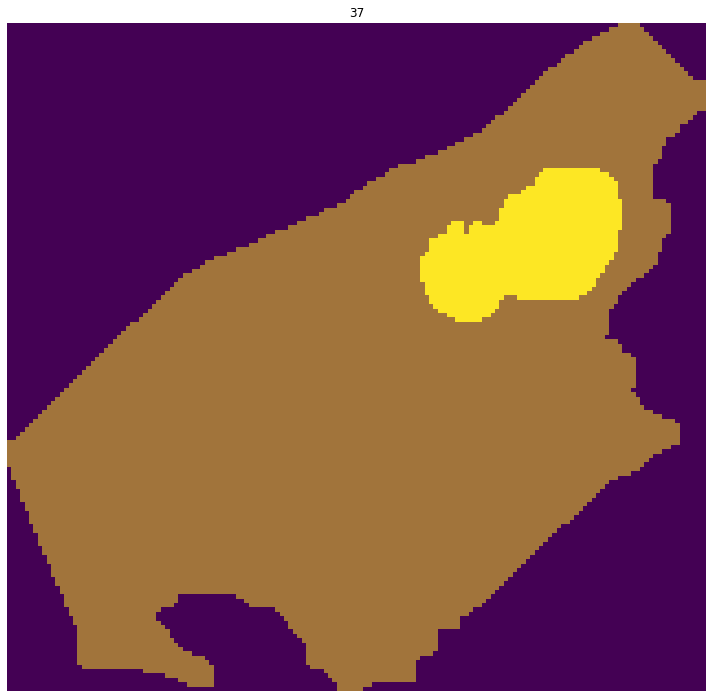

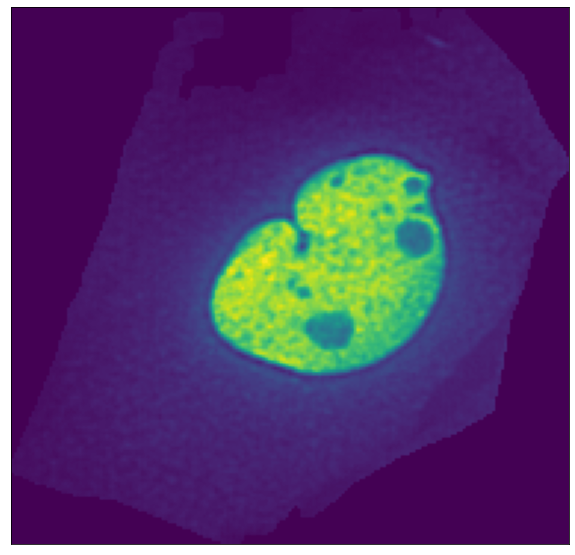

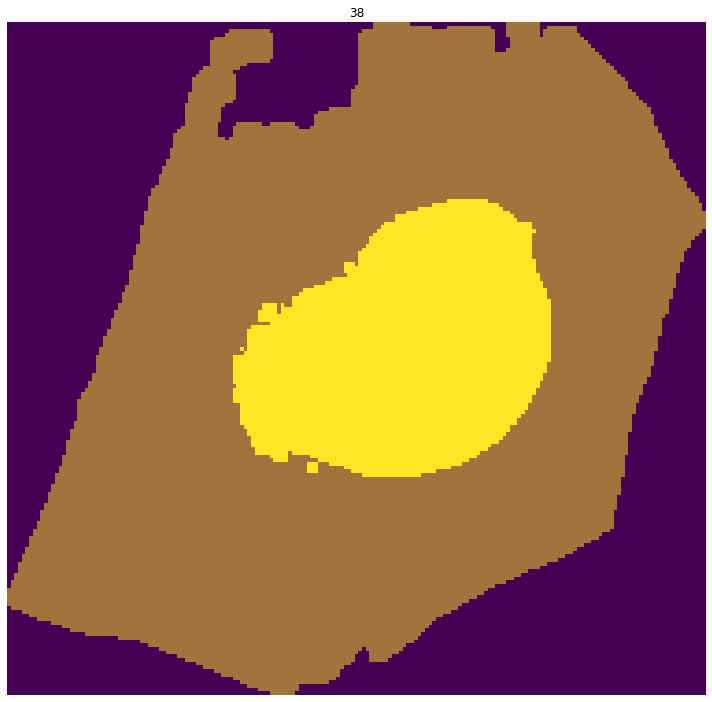

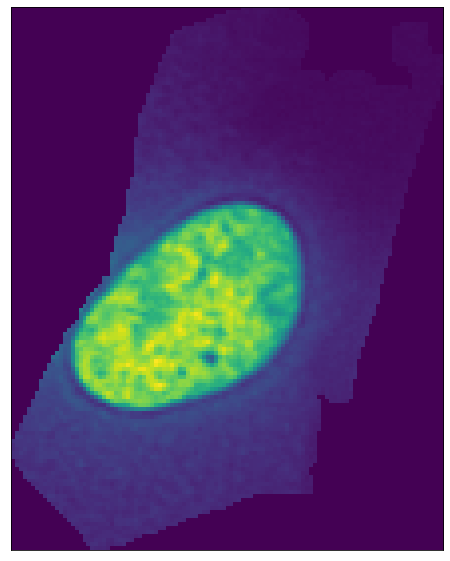

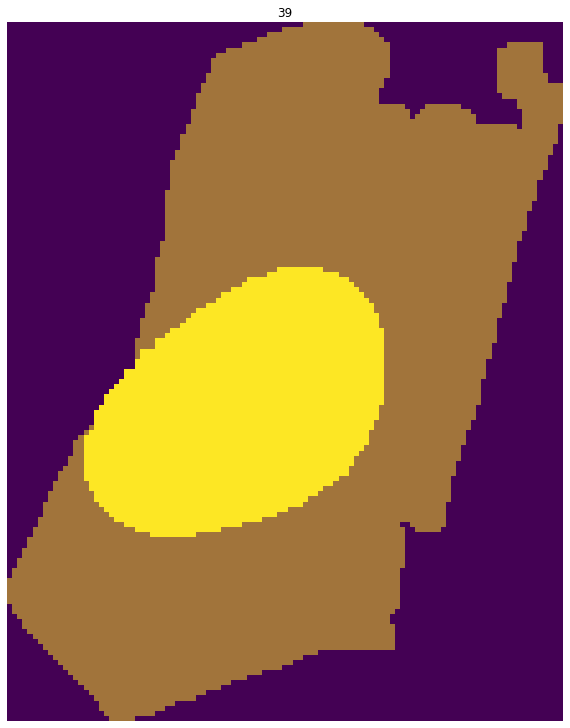

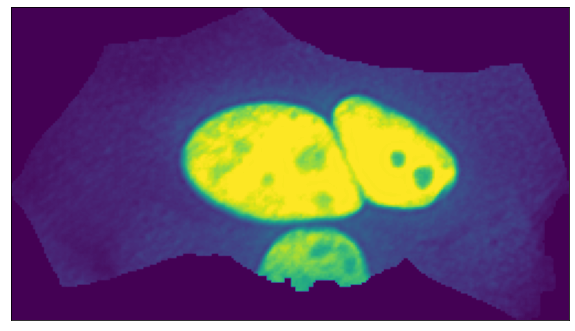

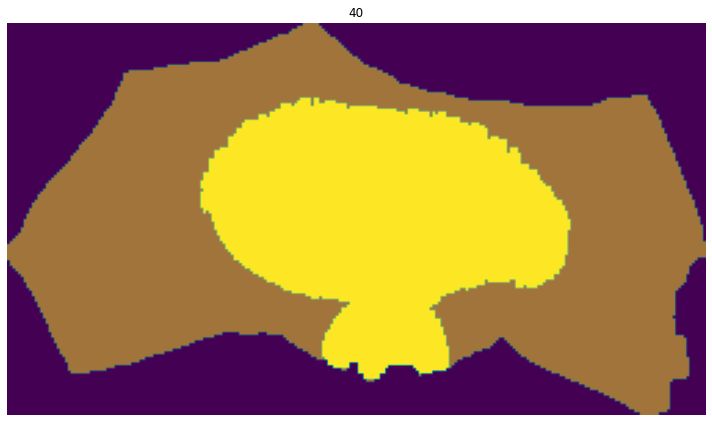

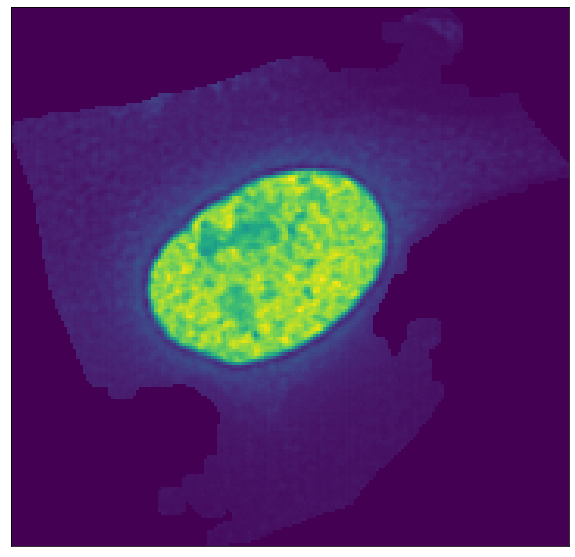

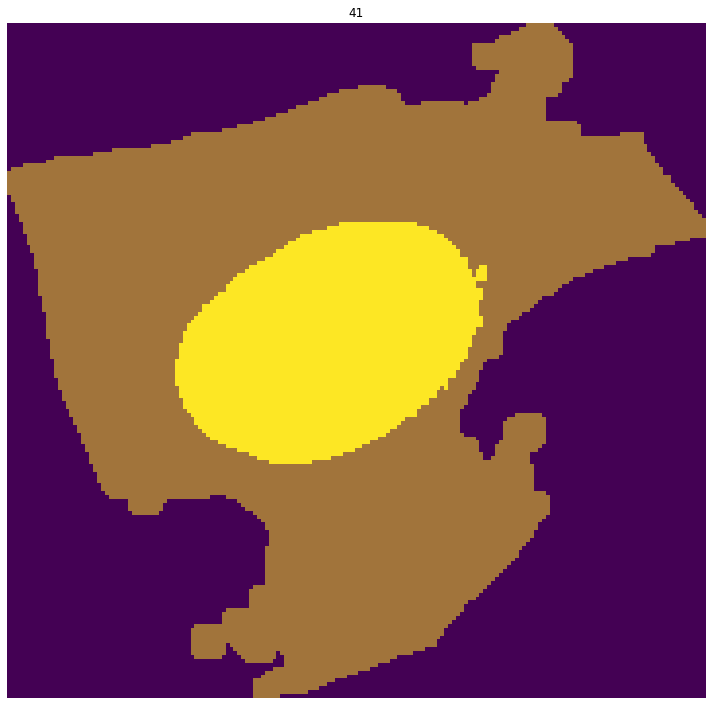

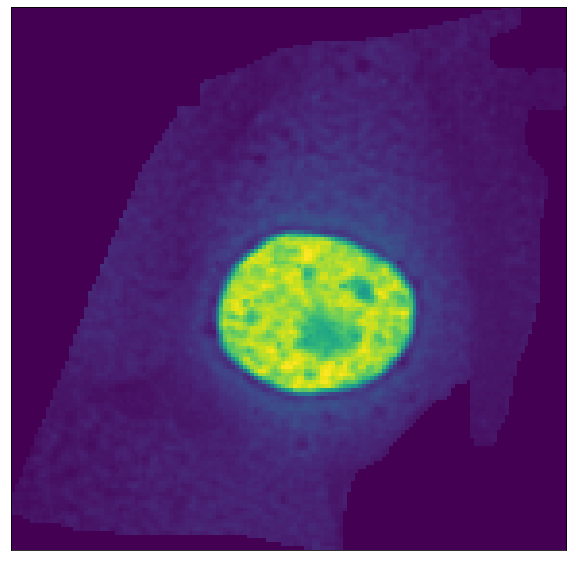

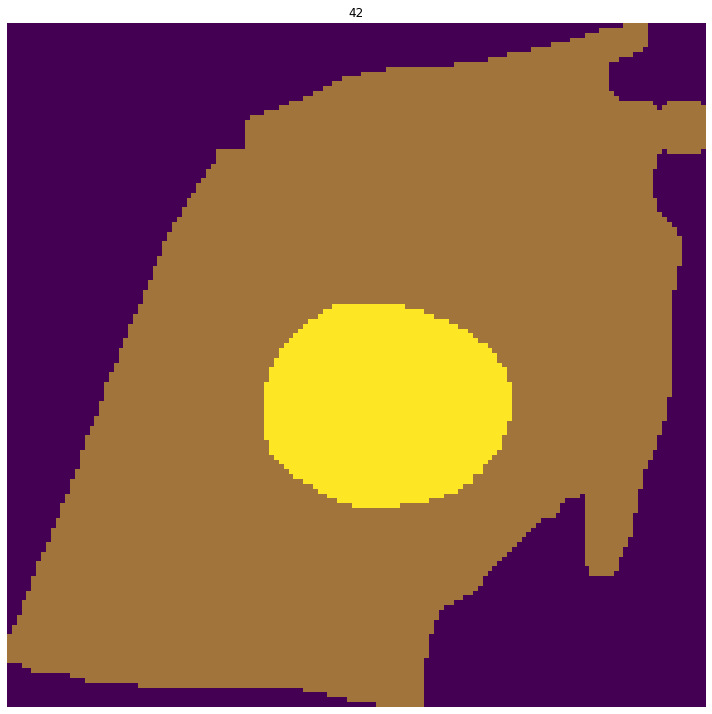

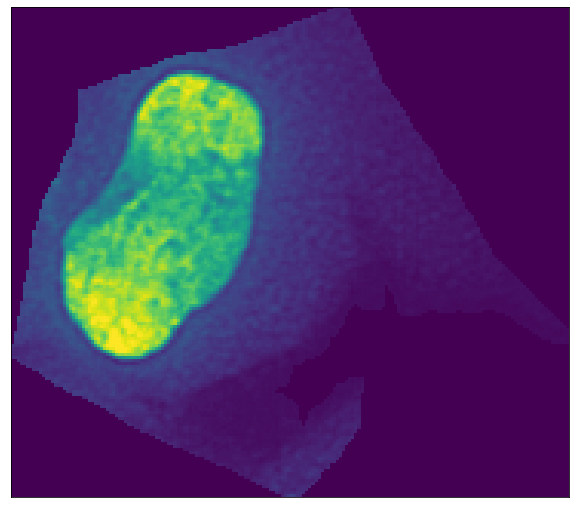

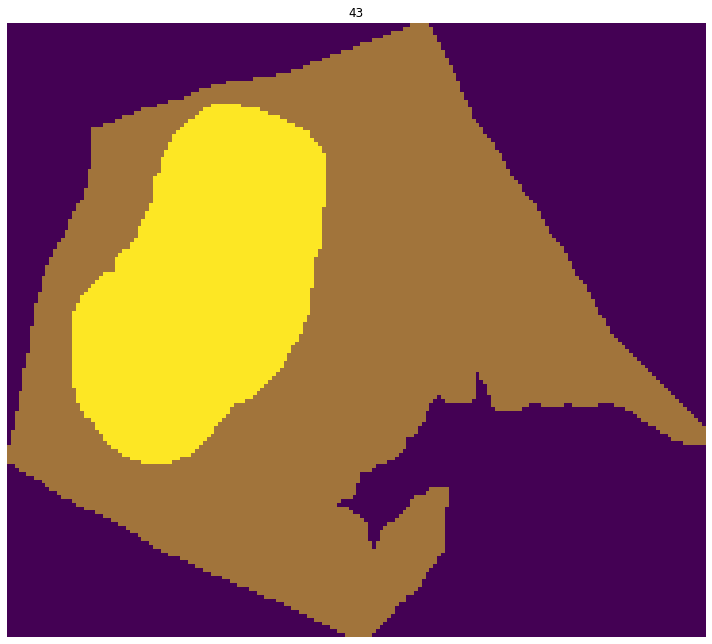

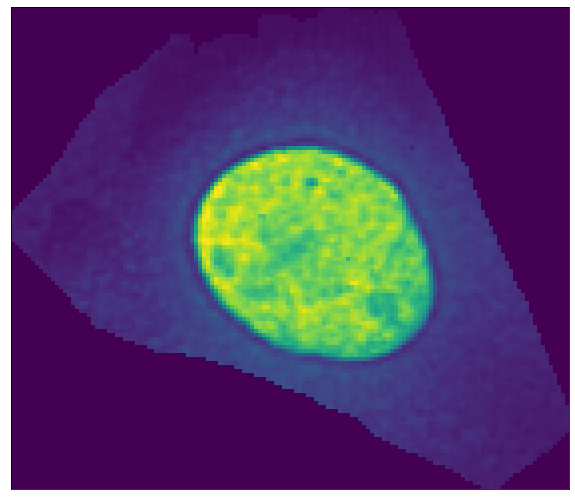

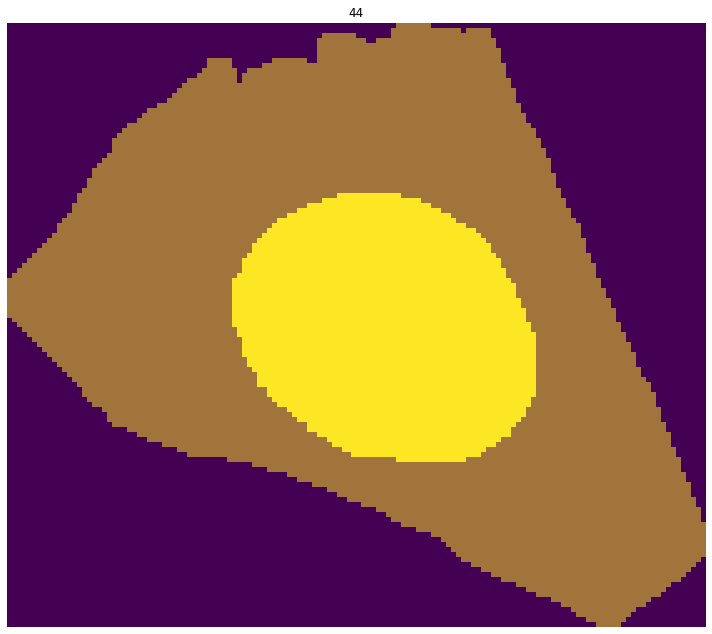

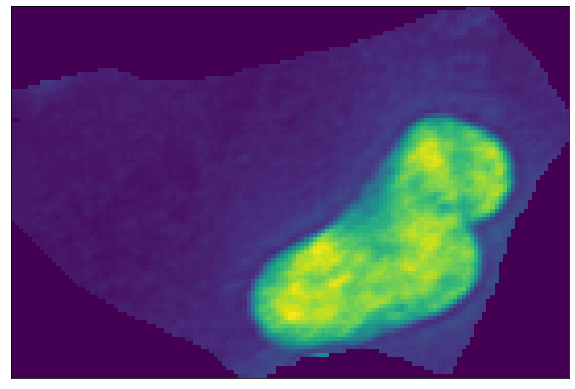

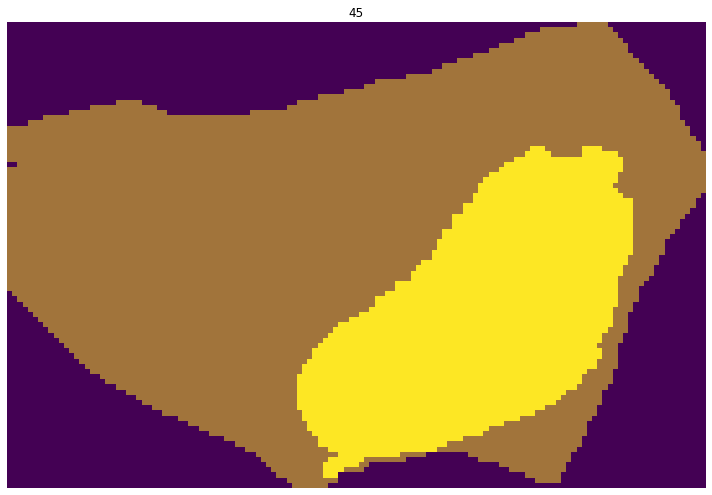

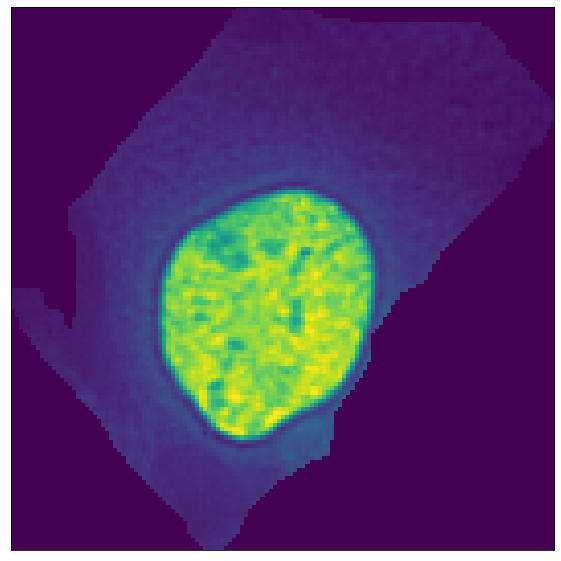

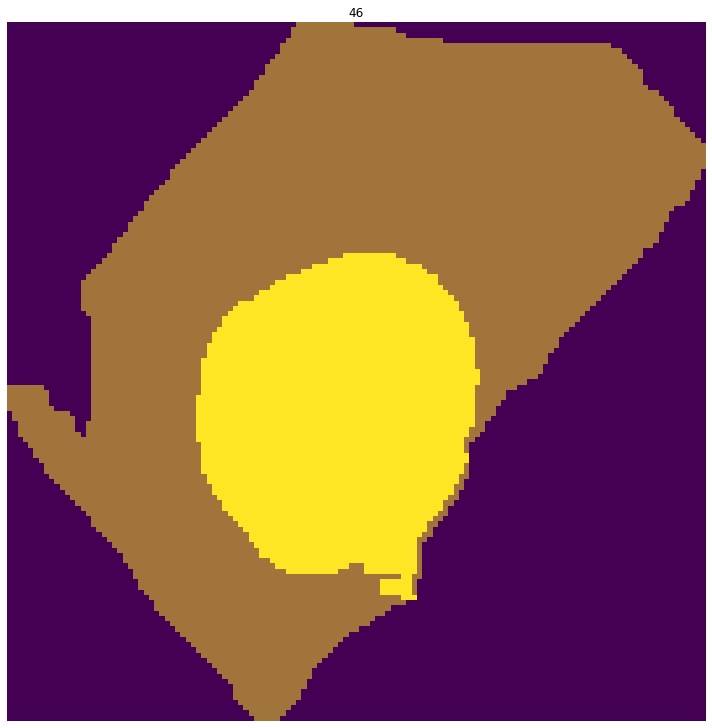

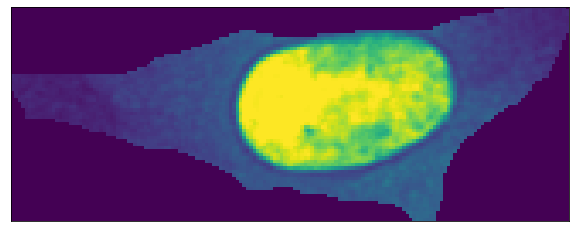

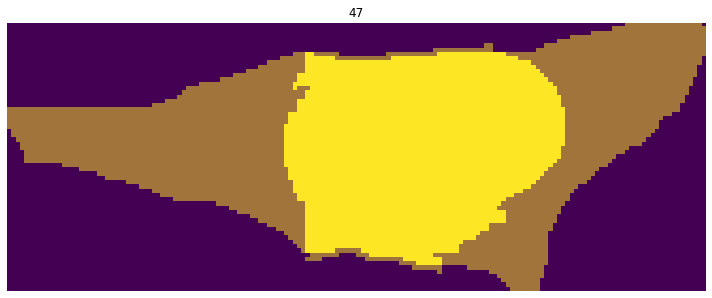

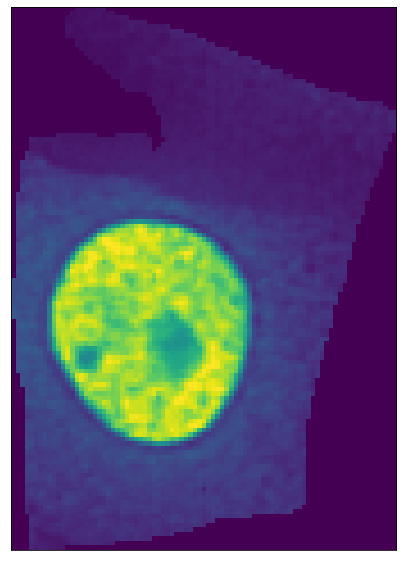

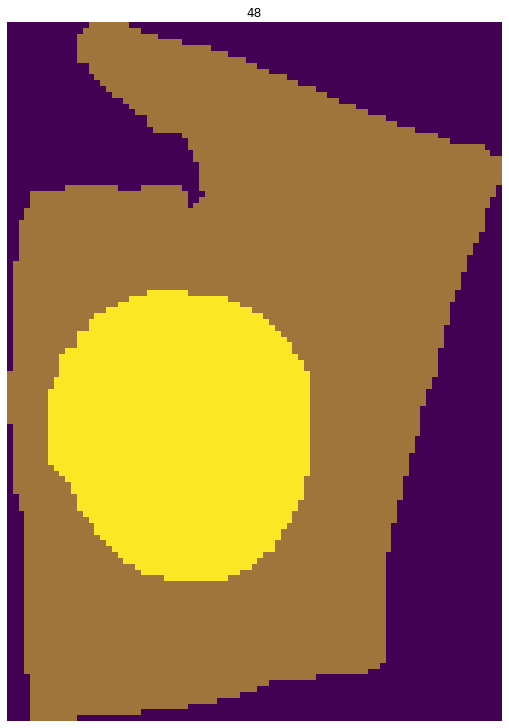

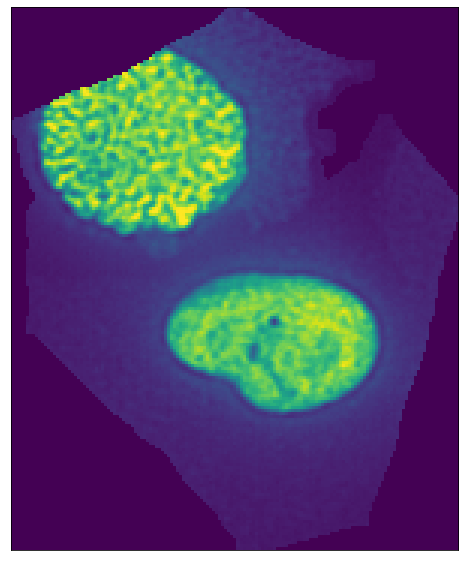

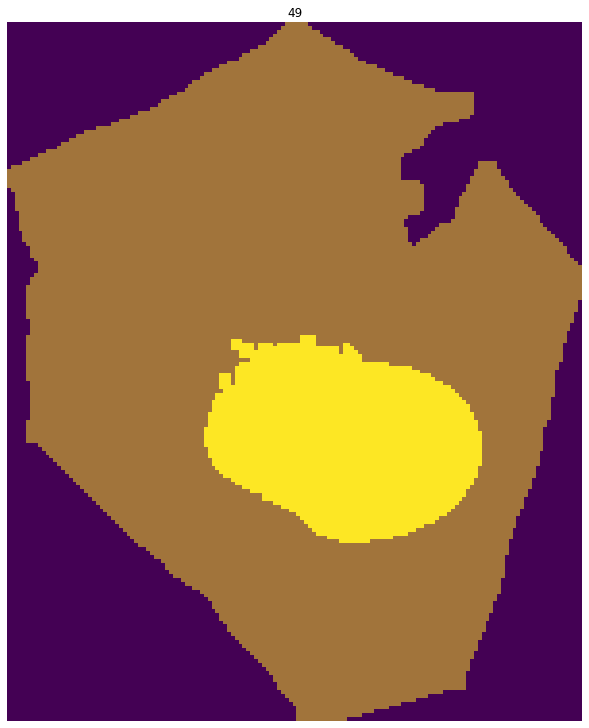

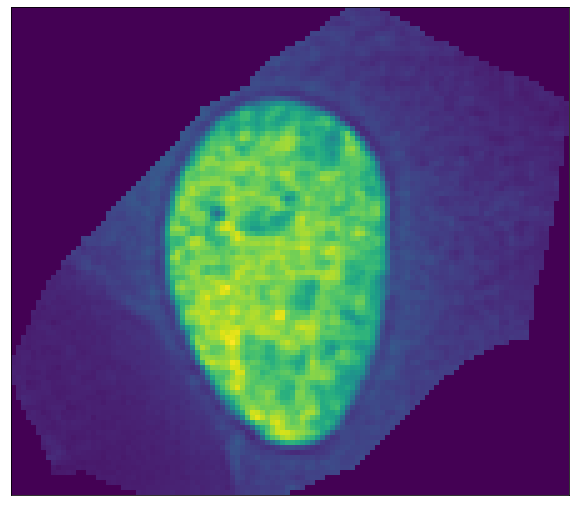

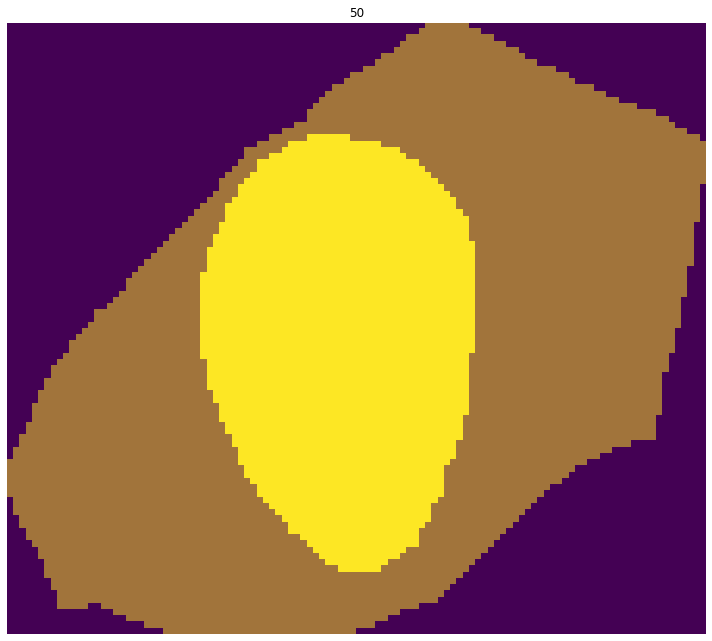

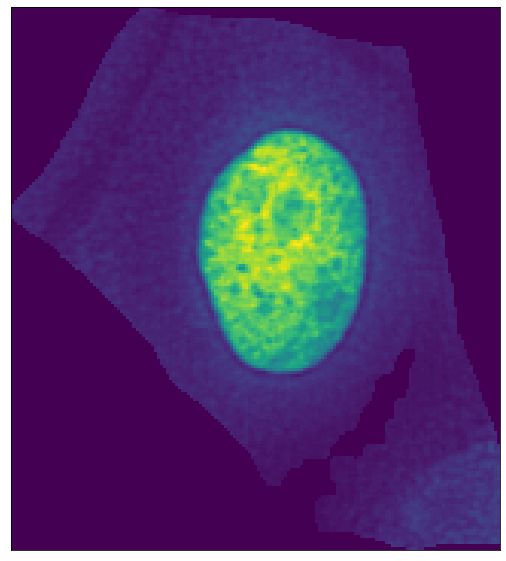

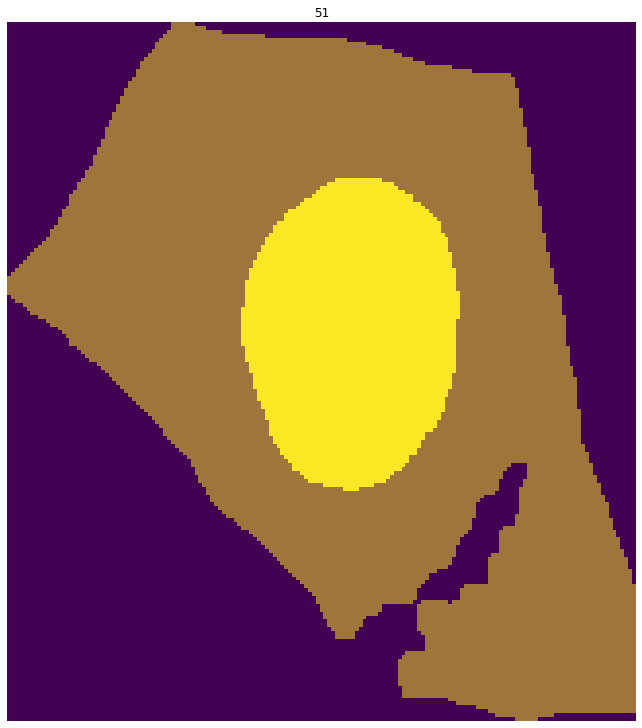

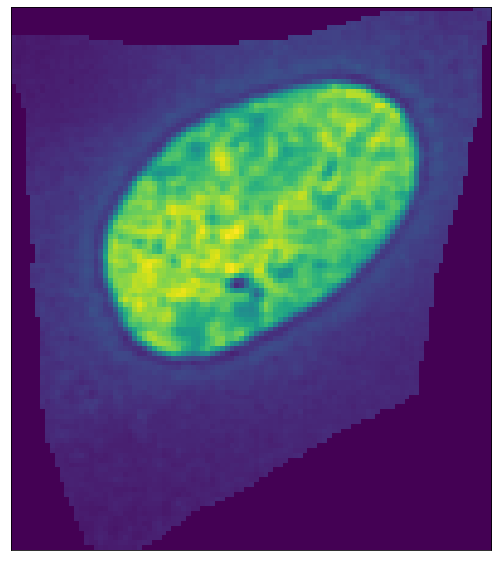

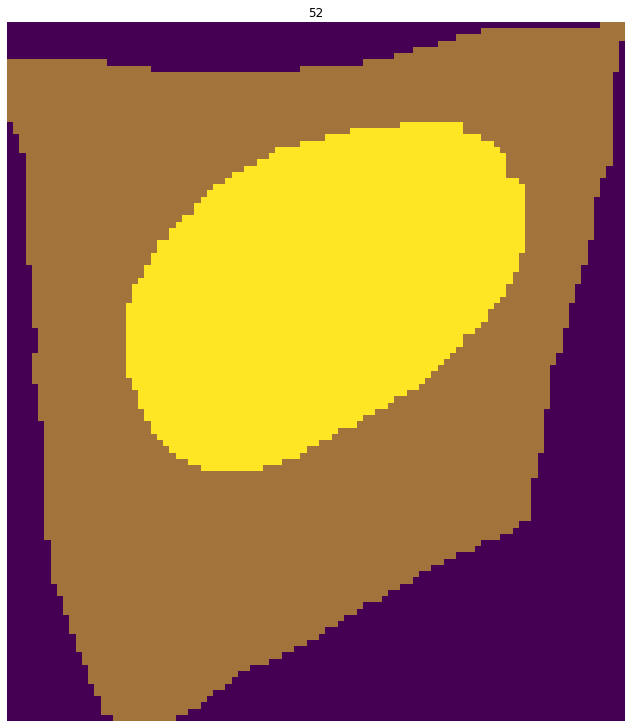

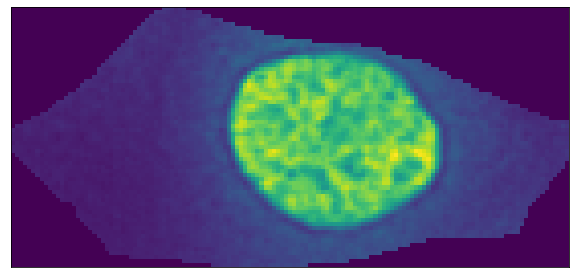

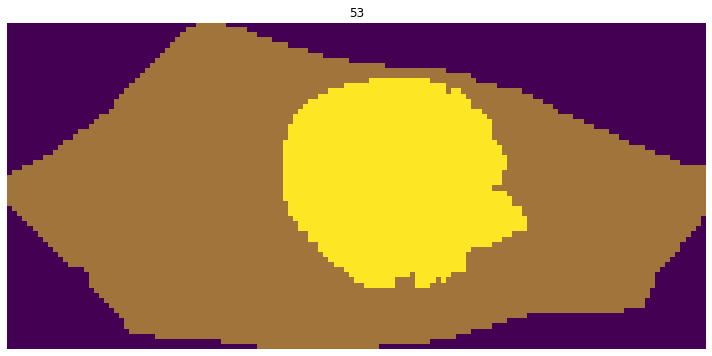

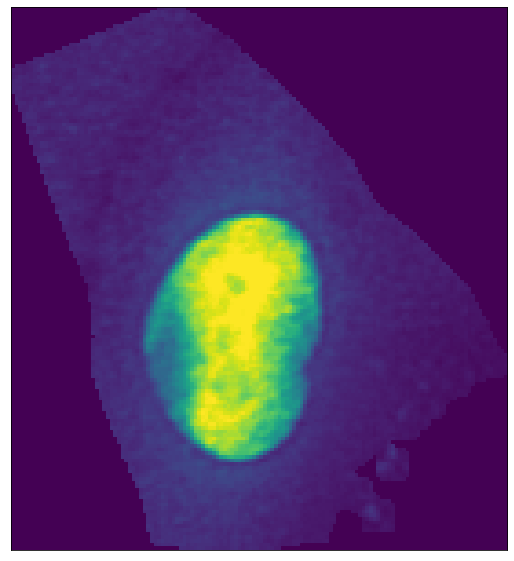

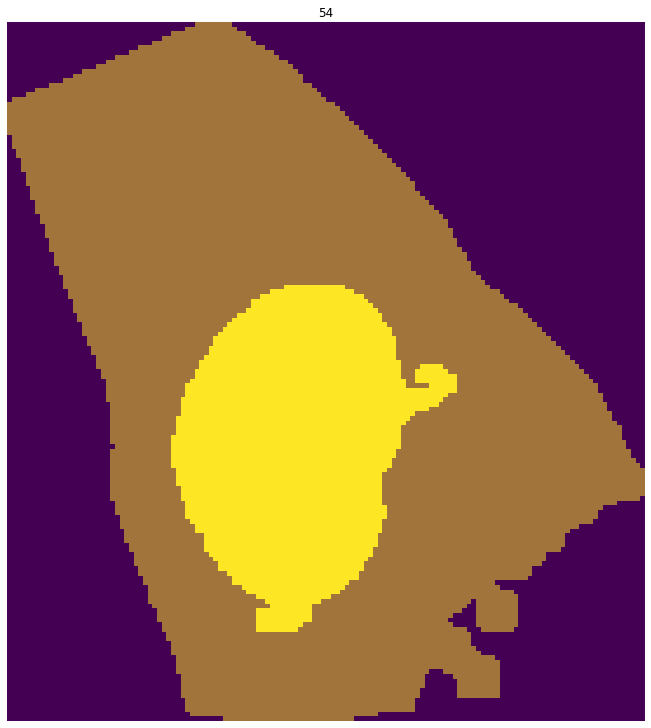

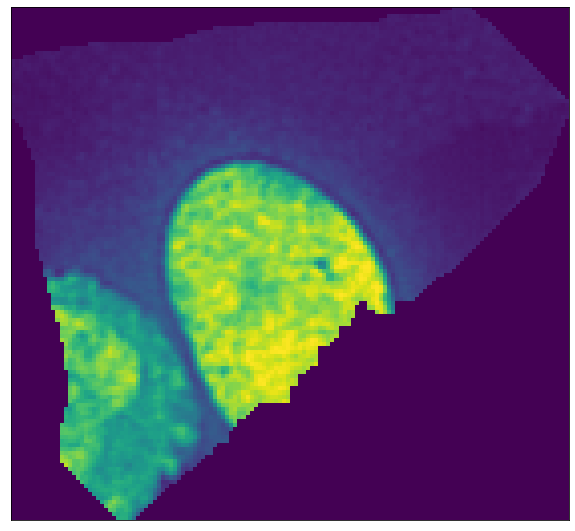

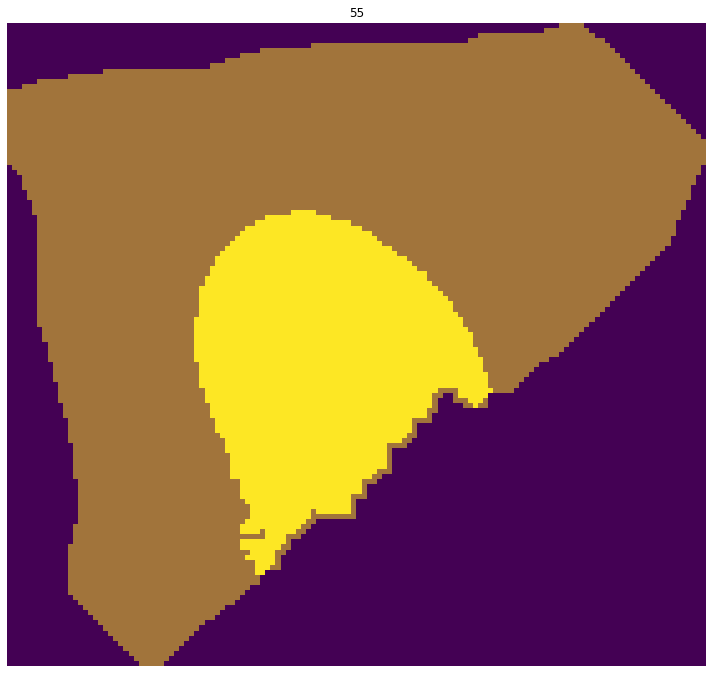

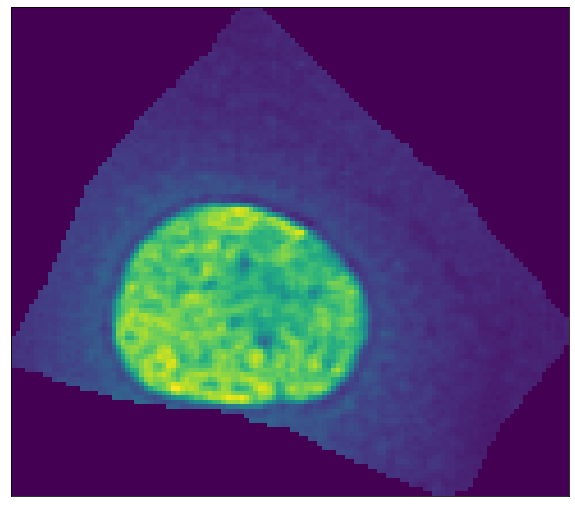

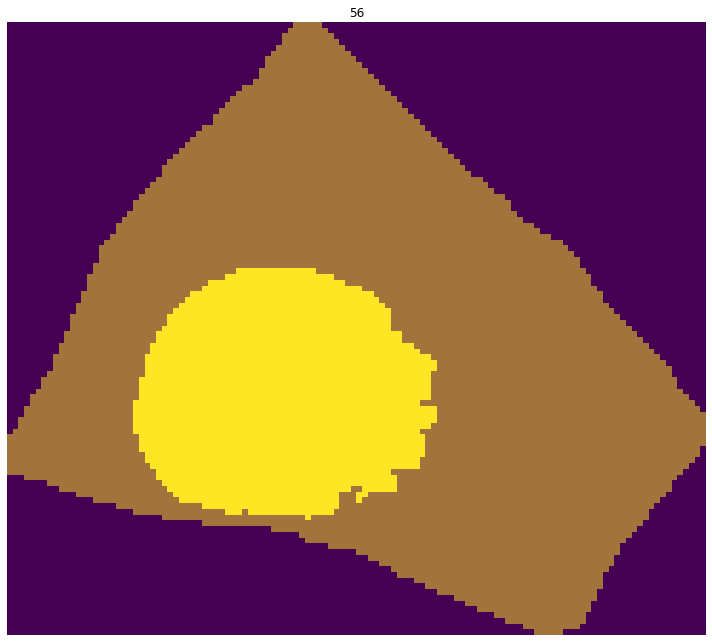

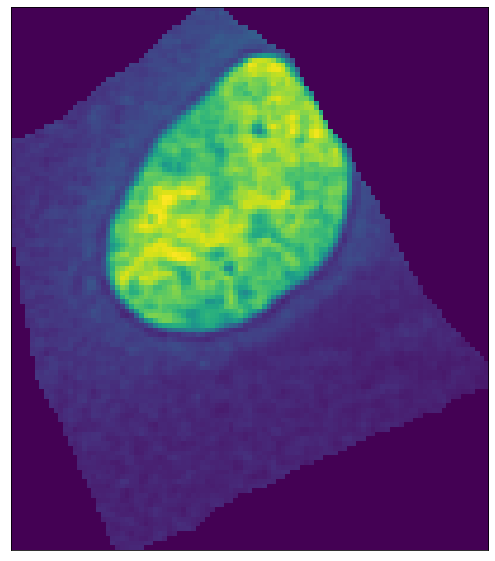

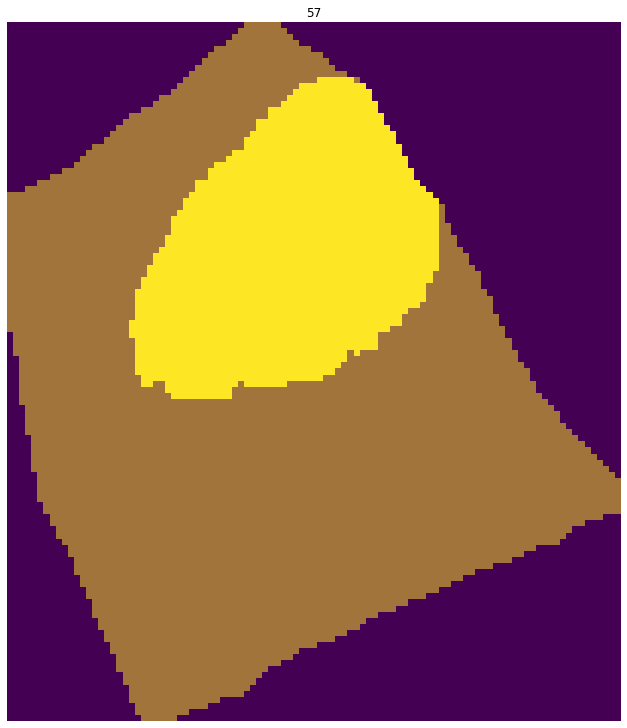

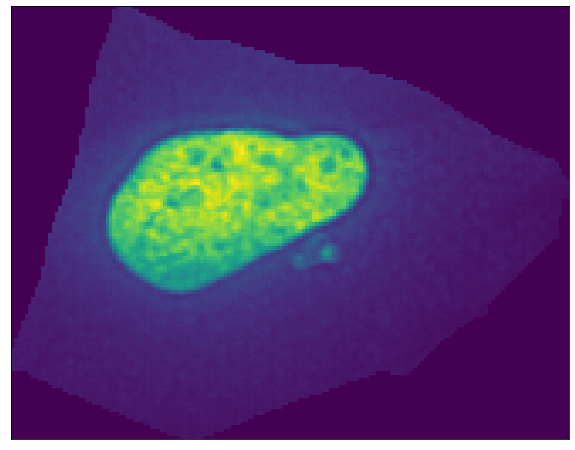

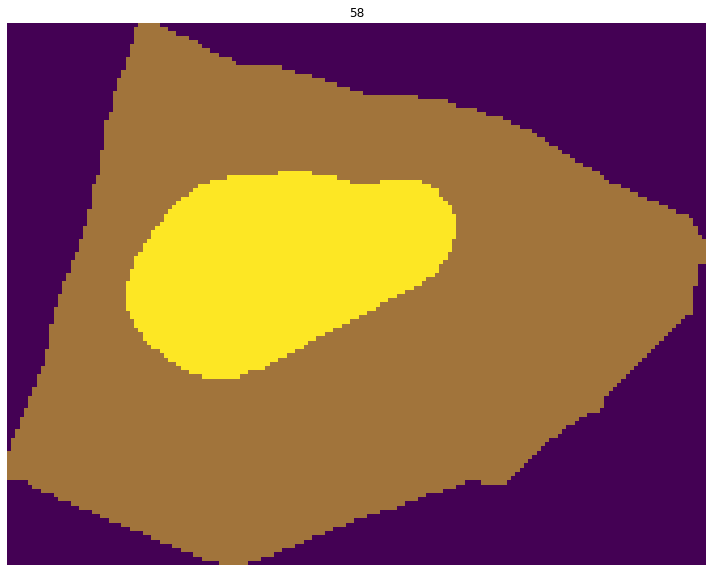

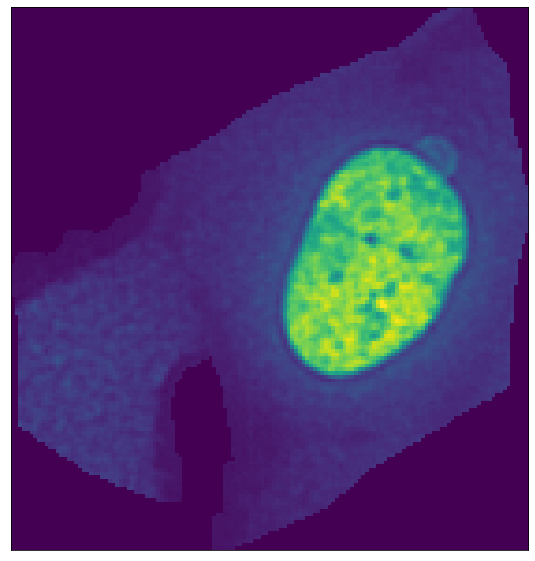

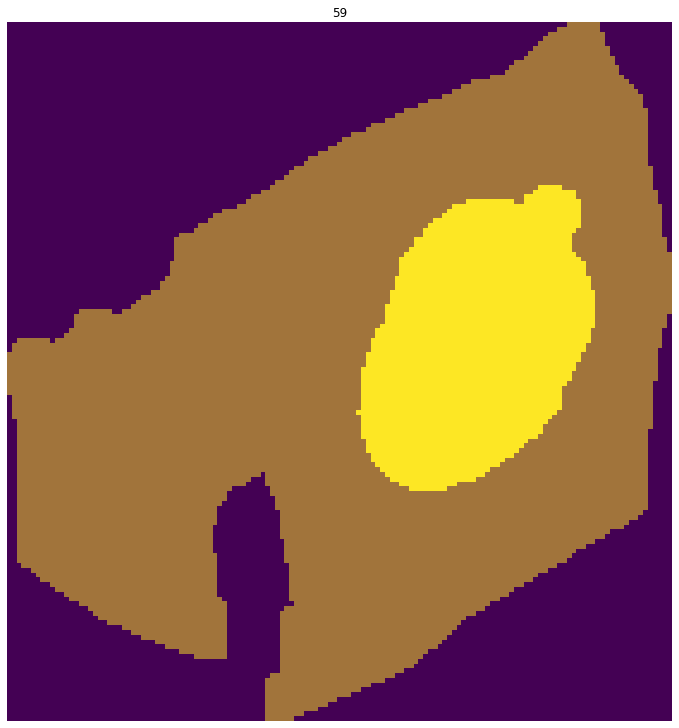

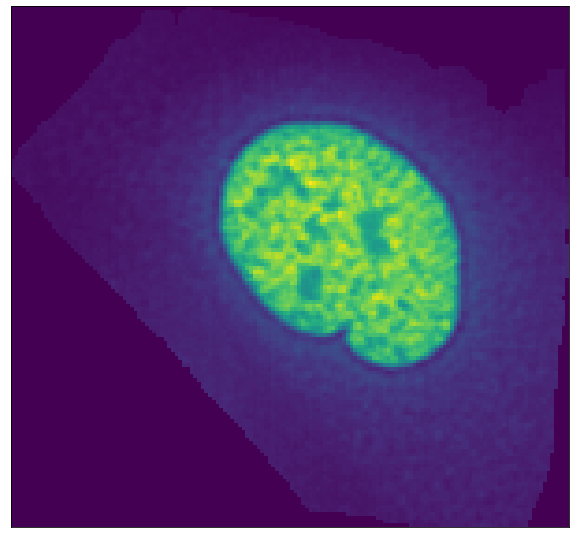

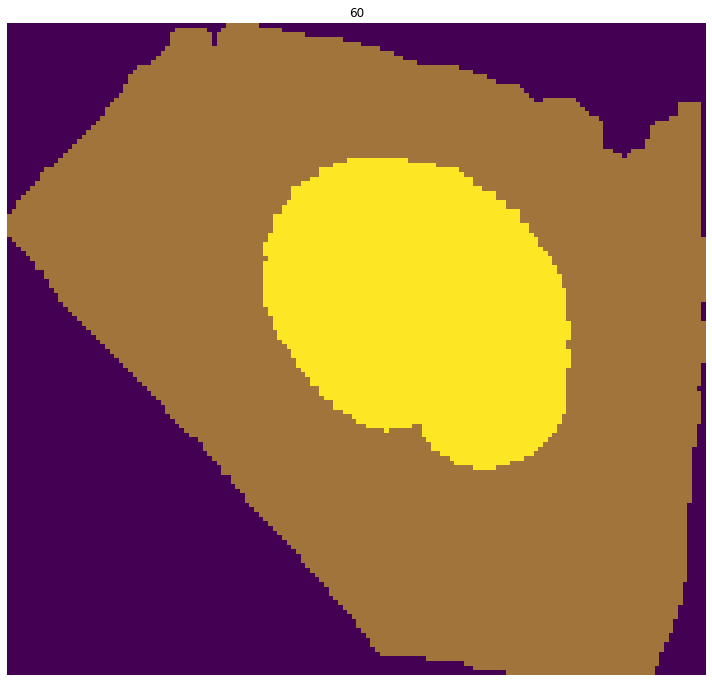

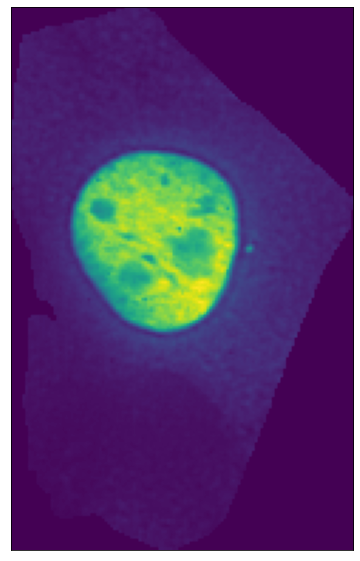

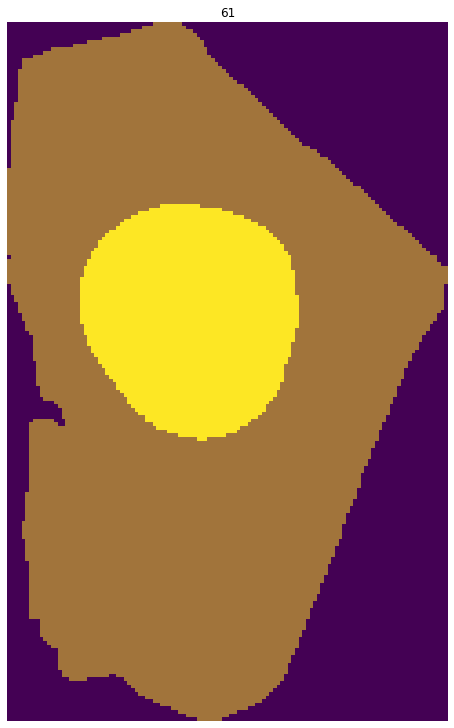

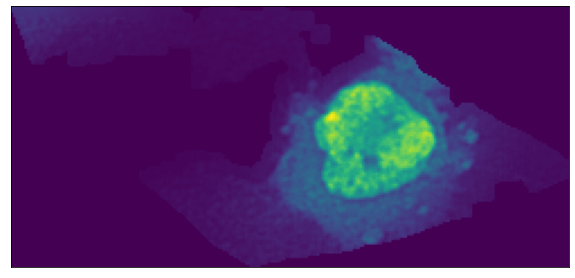

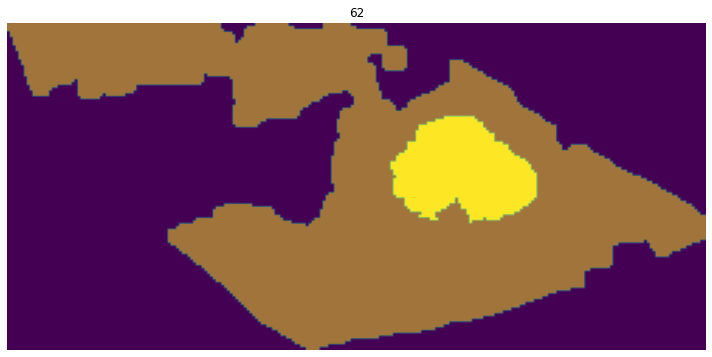

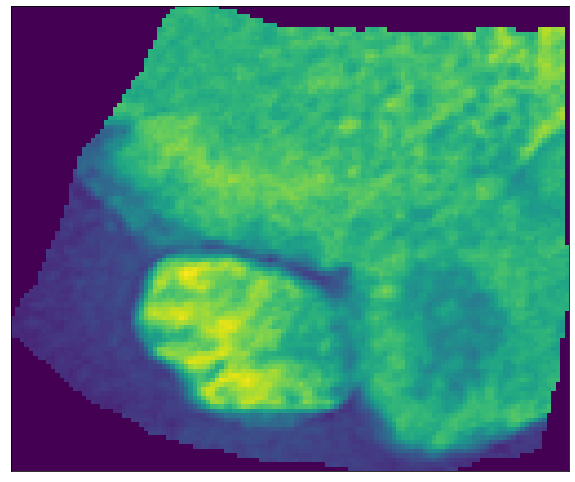

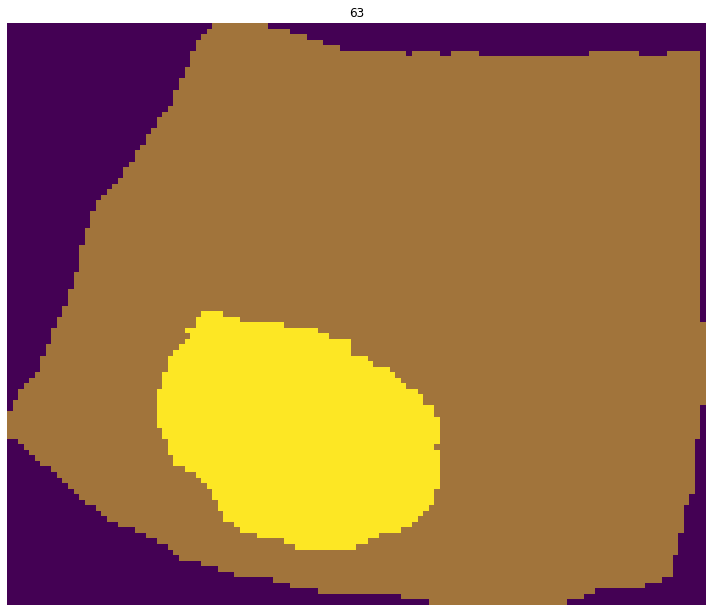

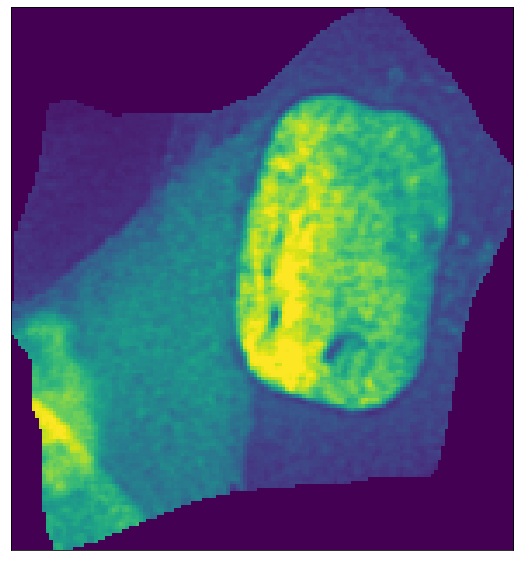

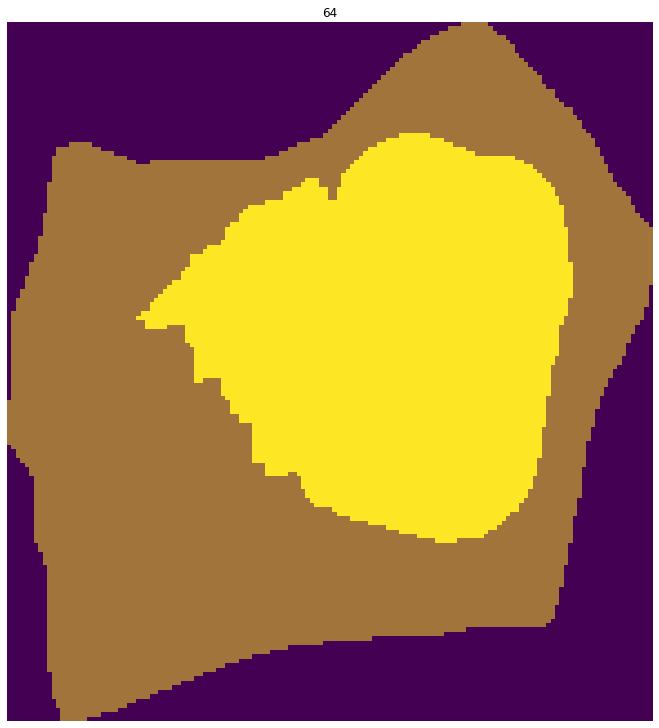

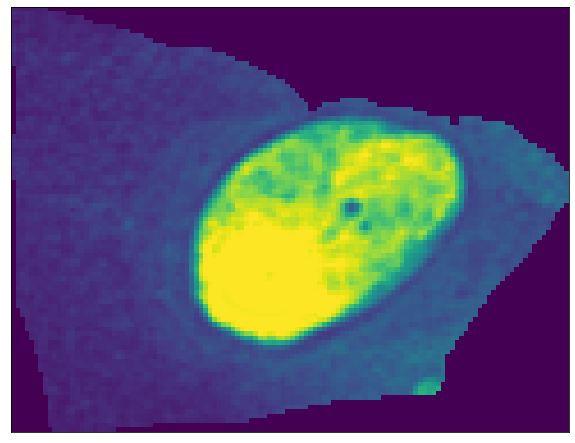

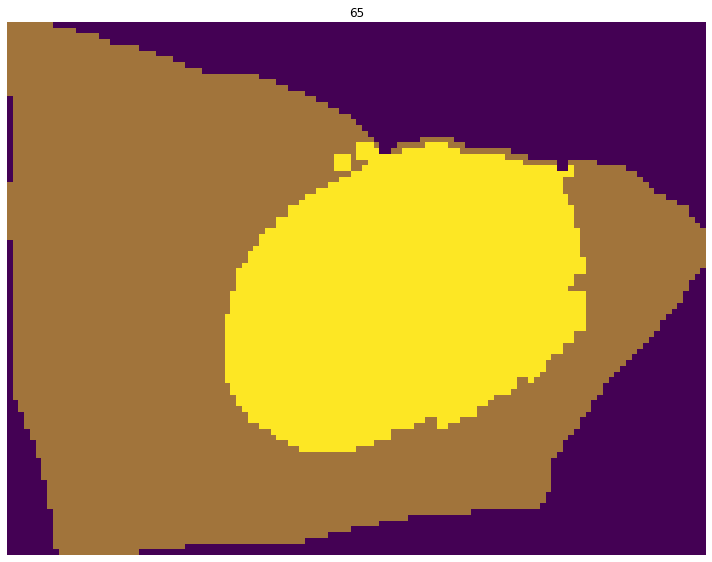

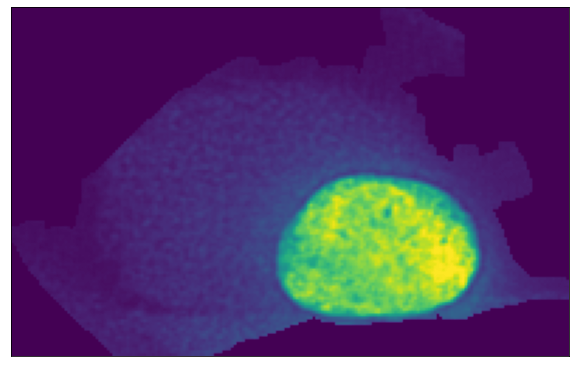

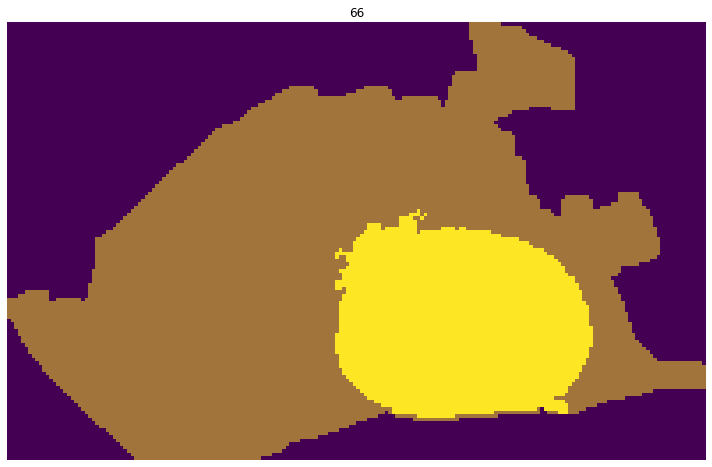

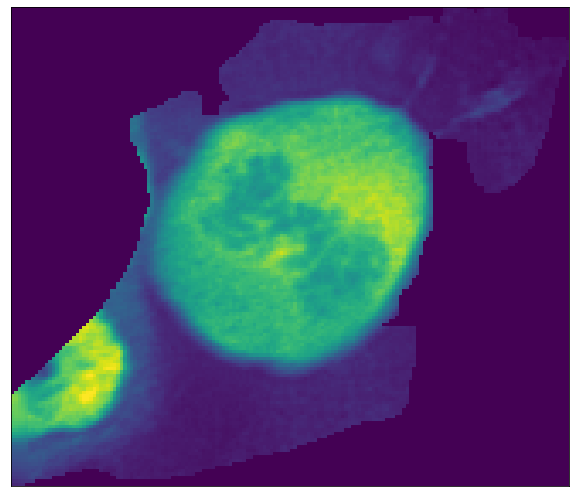

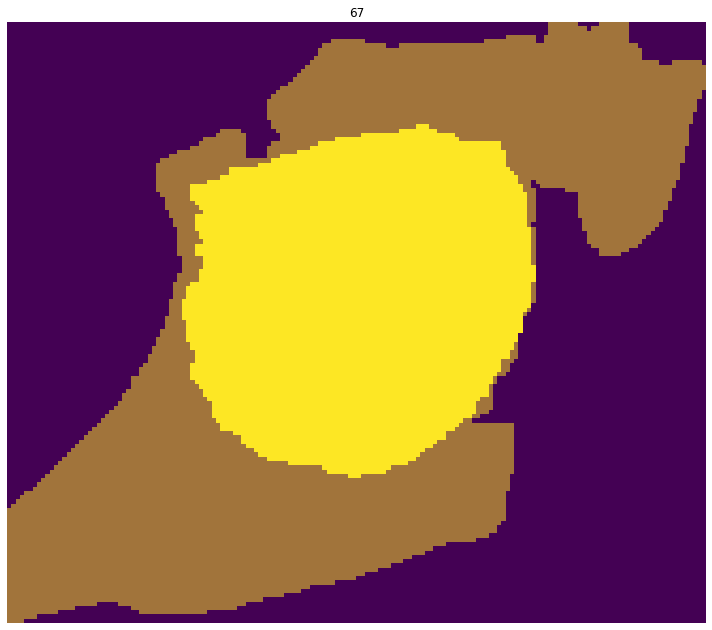

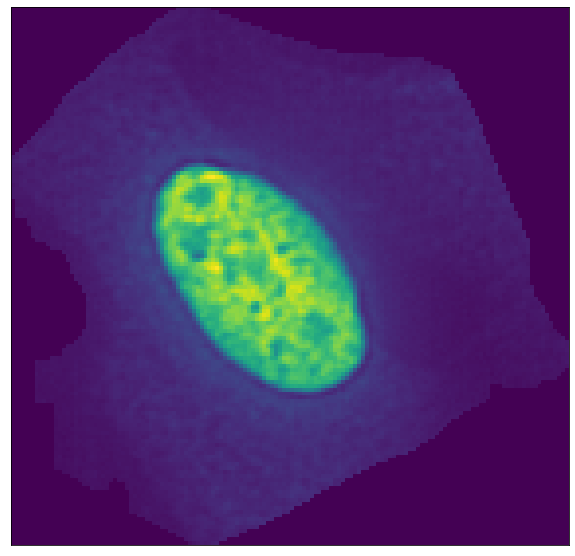

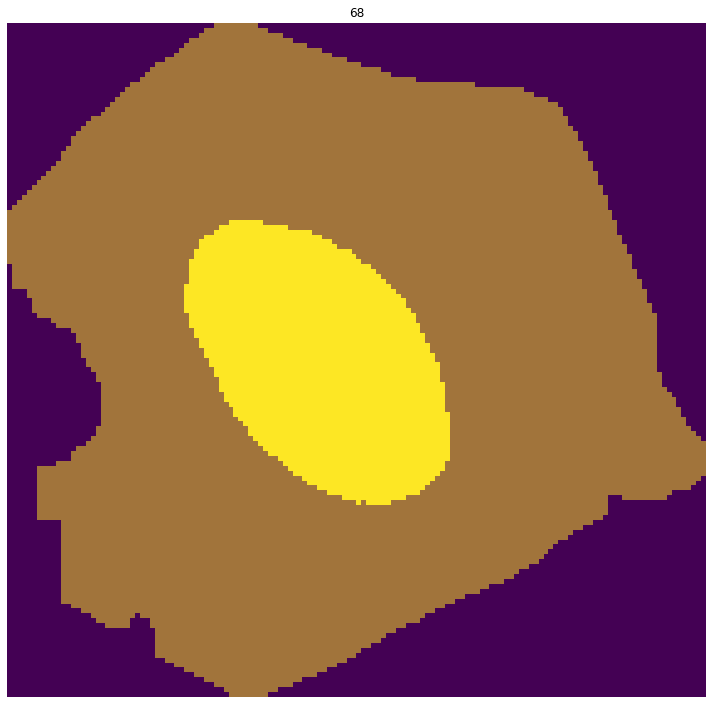

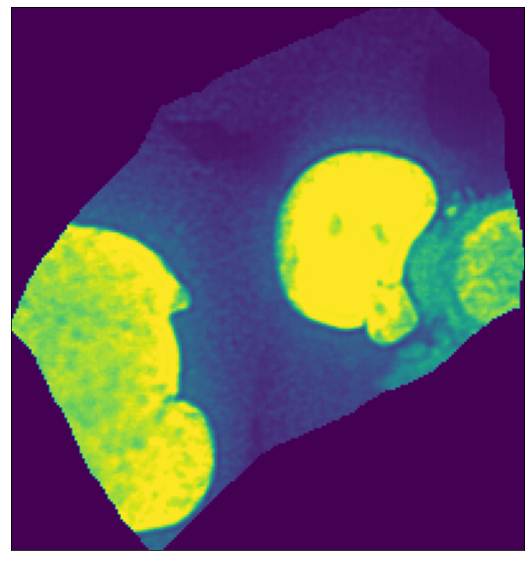

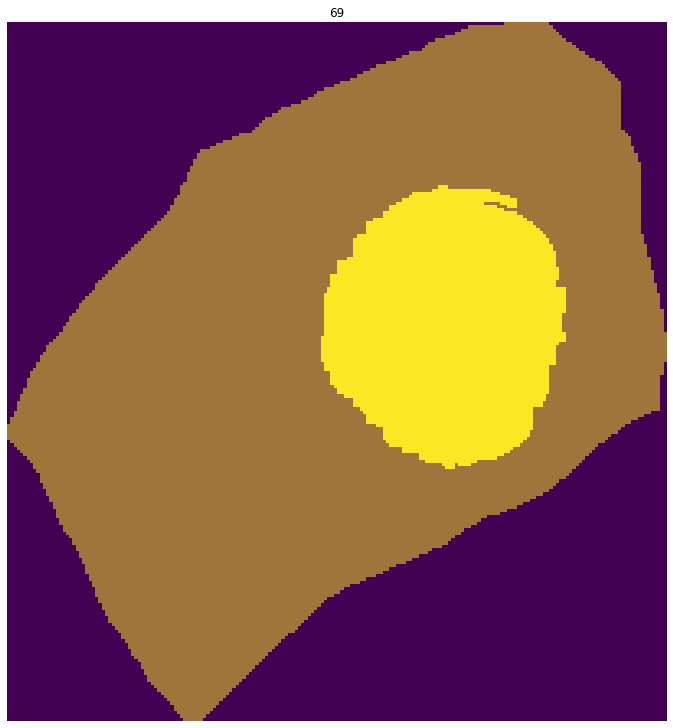

In [96]:
get_single_cell_mask(cell_mask_, nuclei_, protein_,cell_idx, rm_border=True, remove_size=20, plot=True)